<p align="center">
          <img src="https://aws1.discourse-cdn.com/boingboing/original/3X/4/2/42f5e99d1e26bb8588c8b992c82ba4293c4ec838.jpg" width=400>
                                                                                                                            </p>

# Predicting Shark Attacks - WORK IN PROGRESS

This project will attempt to build a model that will be able to predict shark attacks based on various oceanic, astrological, meteorological, and marine life factors. 

## Data

The data used for modeling was obtained from [Kaggle](https://www.kaggle.com/dingo1694/shark-attack) and contains values collected mainly from North and South Carolina Beaches. It is important to note that 61% of the location data is Null, while the remaining 39% indicate the data was collected from the Carolinas. Because this dataset is small, this project worked under the assumption that all data was collected from this region to maintain as much data as possible.

The [Global Shark Attack File](https://www.sharkattackfile.net/incidentlog.htm) was obtained from the [Shark Research Institute](https://www.sharks.org/), an organization dedicated to "inform[ing] and guid[ing] governing bodies and society at large to conservation policies that ensure the sustainability of all shark species." This file contains roughly 4600 reported shark attacks dating back to the mid-1800's. While it does not contain the same oceanic, astrological, meteorological, or marine life measures, it does include location data, activity of the victim, and whether or not the shark was provoked. This data was used to help inform data analysis and model development.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# YOLO
import warnings
warnings.filterwarnings('ignore')

### Load Kaggle Shark Attack Data

**Encountered a UTF-8 ecoding error. The suggestions in this discussion resolved the issue:** https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas-with-python

In [2]:
data = pd.read_csv('sharks.csv', encoding='ISO-8859-1', parse_dates=['Date'])
print(data.shape)
data.head()

(186, 72)


,X.2,X.1,X,Id,Date,ID,TurtleExactCountSC,turtleexactdiscretizeSC,TurtleExactCountNC,TurtleExactCombined,...,StationPressure_minmax,WindSpeed_minmax,Salinity_minmax,Turbidity_minmax,Dissolved02_minmax,WaterTemp_minmax,Turtle_minmax,Crablandings_minmax,turbidity_kmeans_binning,turbidty_domain
0,1,1,1,4,2009-05-04,25,0.0,Low,0.0,0,...,0.578947,0.333333,0.636021,0.032566,0.741354,0.576733,0.000000,0.933566,Low,Low
1,2,2,2,5,2009-05-05,33,0.0,Low,0.0,0,...,0.649123,0.202614,0.552312,0.037936,0.675088,0.477558,0.000000,0.114510,Low,Medium
2,3,3,3,7,2009-05-07,49,1.0,Low,0.0,0,...,0.508772,0.405229,0.496314,0.027615,0.703665,0.498185,0.000000,0.925699,Low,Low
3,4,4,4,8,2009-05-08,57,0.0,Low,0.0,0,...,0.508772,0.267974,0.579198,0.020119,0.788776,0.575743,0.000000,0.296329,Low,Low
4,5,5,5,11,2009-05-11,81,2.0,Low,0.0,1,...,0.614035,0.385621,0.597837,0.066004,0.822323,0.627393,0.004785,0.994755,Low,Medium


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 72 columns):
X.2                                186 non-null int64
X.1                                186 non-null int64
X                                  186 non-null int64
Id                                 186 non-null int64
Date                               186 non-null datetime64[ns]
ID                                 186 non-null int64
TurtleExactCountSC                 151 non-null float64
turtleexactdiscretizeSC            151 non-null object
TurtleExactCountNC                 149 non-null float64
TurtleExactCombined                186 non-null int64
TurtleexactdiscretizeNC            149 non-null object
TurtleAttackActivity               72 non-null float64
TurtleAttackActivityDiscretized    72 non-null object
Area                               72 non-null object
Location                           72 non-null object
Time                               60 non-null object
Species        

### Dealing with Null values and transformed/duplicate data

1. Duplicate Columns
    - ```X```, ```X.1```, ```x.2```, ```Id```, and ```ID``` all appear to be leftover indexing columns from preprocessing before this dataset was made available to the public. The dataframe's current index and the ```Date``` column will suffice for modeling and analysis. **Drop:** ```X```, ```X.1```, ```X.2```, ```Id```, ```ID```
2. Transformed Columns
    - The last 42 columns in the dataset (with the exception of ```CrabLandings```, ```Degree```, and ```Direction```) all appear to have undergone some mathematical transformation, presumably with the intent of feature engineering. However, there is very little documentation accompanying this Kaggle dataset and none it addresses these transformed columns. While these transformations may have been performed to aid users, I can not be sure it was done correctly. Thus, **these columns will be dropped** (again, with the exception of ```CrabLandings``` and ```Degree```)
        - ```Direction``` and ```Degree``` both indicate wind direction, but ```Degree``` is more informative. Thus, ```Direction``` will be **dropped**.
    - The ```MoonPhaseExtended``` column does not appear to add any significant value to the dataset that is not already in the ```MoonPhase``` column. The phases of the moon are cyclical and it takes roughly 29.5 days for the moon to complete one cycle through its 7 phases (source: [The Lunar and Planetary Institute](https://www.lpi.usra.edu/education/skytellers/moon-phases/#targetText=It%20takes%2027%20days%2C%207,new%20Moon%20to%20new%20Moon)). Therefore, forecasting the phase of the moon beyond the date recorded would be simple. **Drop:** ```MoonPhaseExtended```
    - Turtle activity could be a strong indicator of shark activity as they are prey for several species of sharks. Thus, it would be beneficial to include at least one of the columns in the dataset pertaining to turtle activity. The ```TurtleExactCombined``` column appears to be the most complete as it has zero Null values, but it also seems to be a transformed column where its values represent the sum of the ```TurtleExactCountSC``` and ```TurtleExactCountNC``` columns. Again, as this is an assumption and I can not be sure this transformation was done correctly, I will create a ```TurtleCount``` column that represents the sum of the ```TurtleExactCountSC``` and ```TurtleExactCountNC``` columns. **The other columns pertaining to turtle counts will be dropped.**
3. Null Values
    - Location columns (```Location```, ```Area```, ```Beach```, and ```County```) have a significant number of Null values. Again, the documentation for this dataset is lacking information regarding where this data was collected and therefore does not help in addressing these Null values. However, 39% of the values in the ```Location``` column are either North Carolina or South Carolina and the columns pertaining to turtle activity mention NC and SC. Thus, it will be assumed that all observation in the dataset were recorded in the Carolina region of the United States. Because all data will be assumed to have come from the Carolinas, location data will not add anything to modeling or analysis and thus will be **dropped.**
    - ```Time```, ```Timeofattack```, and ```Species``` columns also have a significant number of null values with no means of imputation. Thus, they will be dropped from the modeling portion of the project. They may add valuable information to the analysis portion of the project and could aid in describing trends of shark attacks in the Carolinas. Therefore, this data will be used for analysis.
    - The rest of the columns with Null values (```Precipitation_Value```, ```StationPressure```, ```WindSpeed```, ```Salinity```, ```Turbidity```, ```Temperature```, and ```DissovedO2```) have only four missing observations. Thus, **these rows will be dropped.**

In [4]:
# Drop columns as outlined above. Since the number of columns to drop is greater than the number of columns to keep,
# slice the df for only the columns that are going to be used

keep_cols = ['Date','TurtleExactCountSC','TurtleExactCountNC','Time','Species', 'Attack', 'Timeofattack','MoonPhase', 
             'Precipitation_Value','StationPressure', 'WindSpeed', 'Salinity', 'Turbidity', 'Temperature',
             'DissovedO2','CrabLandings', 'Degree']

data2 = data[keep_cols]

data2.head()

,Date,TurtleExactCountSC,TurtleExactCountNC,Time,Species,Attack,Timeofattack,MoonPhase,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2,CrabLandings,Degree
0,2009-05-04,0.0,0.0,NaN,NaN,No,NaN,First quarter,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556,1070,223.355556
1,2009-05-05,0.0,0.0,NaN,NaN,No,NaN,First quarter,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444,133,206.222222
2,2009-05-07,1.0,0.0,NaN,NaN,No,NaN,Waxing gibbous,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111,1061,212.111111
3,2009-05-08,0.0,0.0,NaN,NaN,No,NaN,Waxing gibbous,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444,341,222.977778
4,2009-05-11,2.0,0.0,NaN,NaN,No,NaN,Full,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444,1140,34.022222


In [5]:
# check results
data2.isna().sum()

Date                     0
TurtleExactCountSC      35
TurtleExactCountNC      37
Time                   126
Species                134
Attack                   0
Timeofattack           114
MoonPhase                0
Precipitation_Value      4
StationPressure          4
WindSpeed                4
Salinity                 4
Turbidity                4
Temperature              4
DissovedO2               4
CrabLandings             0
Degree                   0
dtype: int64

In [6]:
# Create the TurtleCount column by adding together the values in the TurtleExactCountNC and the TurtleExactCountSC
# columns. Fill the null values in the TurtleCount column with its median value. 
# Then drop the individual NC and SC turtle count columns
        
data2['TurtleCount'] = data2['TurtleExactCountSC'] + data2['TurtleExactCountNC']

attacks_df = data2[data2.Attack == 'Yes']
print('Number of Null Values for Shark Attack Observations: ', attacks_df.TurtleCount.isna().sum())
print("\n")

data2 = data2.fillna(value={'TurtleCount': 11.0}, axis=0)
data2 = data2.drop(['TurtleExactCountSC', 'TurtleExactCountNC'], axis=1)
data2.info()



Number of Null Values for Shark Attack Observations:  72


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 16 columns):
Date                   186 non-null datetime64[ns]
Time                   60 non-null object
Species                52 non-null object
Attack                 186 non-null object
Timeofattack           72 non-null object
MoonPhase              186 non-null object
Precipitation_Value    182 non-null float64
StationPressure        182 non-null float64
WindSpeed              182 non-null float64
Salinity               182 non-null float64
Turbidity              182 non-null float64
Temperature            182 non-null float64
DissovedO2             182 non-null float64
CrabLandings           186 non-null int64
Degree                 186 non-null float64
TurtleCount            186 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(1), object(5)
memory usage: 23.3+ KB


In [7]:
# Create a df for modeling and drop its remaining Null values

model_df = data2.drop(['Time', 'Species', 'Timeofattack'], axis=1)
model_df = model_df.dropna()
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 0 to 181
Data columns (total 13 columns):
Date                   182 non-null datetime64[ns]
Attack                 182 non-null object
MoonPhase              182 non-null object
Precipitation_Value    182 non-null float64
StationPressure        182 non-null float64
WindSpeed              182 non-null float64
Salinity               182 non-null float64
Turbidity              182 non-null float64
Temperature            182 non-null float64
DissovedO2             182 non-null float64
CrabLandings           182 non-null int64
Degree                 182 non-null float64
TurtleCount            182 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory usage: 19.9+ KB


In [8]:
# Binarize target column
model_df.loc[(model_df.Attack == 'No'), 'Attack'] = 0
model_df.loc[(model_df.Attack == 'Yes'), 'Attack'] = 1
print(model_df.Attack.value_counts())
model_df.head()

0    114
1     68
Name: Attack, dtype: int64


,Date,Attack,MoonPhase,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2,CrabLandings,Degree,TurtleCount
0,2009-05-04,0,First quarter,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556,1070,223.355556,0.0
1,2009-05-05,0,First quarter,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444,133,206.222222,0.0
2,2009-05-07,0,Waxing gibbous,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111,1061,212.111111,1.0
3,2009-05-08,0,Waxing gibbous,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444,341,222.977778,0.0
4,2009-05-11,0,Full,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444,1140,34.022222,2.0


### Load Global Shark Attack File

While this dataset is maintained by the Shark Research Institute, it is fairly messy. There are a significant amount of Null values and there is inconsistent data types within the columns. Considerable preprocessing will be necessary before the dataset is usable for analysis.

Preprocessing Tasks:
* Drop the last 19,000 as they are comprised of only Null values
* 

In [9]:
gsaf = pd.read_excel("GSAF5.xls", nrows=6451)
gsaf = gsaf.drop(['Investigator or Source', 'pdf', 'href formula', 'href', 'original order', 'Case Number.1', 
                  'Case Number.2','Unnamed: 22', 'Unnamed: 23'], axis=1)
#gsaf['Date'] = pd.to_datetime(gsaf['Date'])
gsaf.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species
0,2019.08.27,27-Aug-2019,2019.0,Provoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Donald Walsh,M,40,Hand and calf bitten when he jumped off surfbo...,N,11h55,6.5' shark
1,2019.08.21,21-Aug-2019,2019.0,Unprovoked,USA,Florida,"Fort Lauderdale, Broward County",Wading,Christian Mariani,M,11,Foot bitten,N,09h00,NaN
2,2019.08.20,20-Aug-2019,2019.0,Unprovoked,USA,Hawaii,"Napoopoo Park in Kealakekua Bay, The Big Island",Swimming,female,F,26,Injury to lower back and right hip,N,08h00,NaN
3,2019.08.16,16-Aug-2019,2019.0,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Wading,Maggie Crum,M,9,Puncture marks to lower leg,N,11h00,NaN
4,2019.08.11,11-Aug-2019,2019.0,Unprovoked,USA,Hawaii,"Makaha Beach, Oahu",Surfing,Max Keliikipi,M,16,"No injury, board damaged",N,19h30,10' to 12' shark


In [10]:
# correct weird formatting issues with column names
gsaf.columns = ['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex', 'Age', 'Injury', 'Fatal (Y/N)', 'Time',
       'Species']

In [11]:
# change data type to string for regex
gsaf['Case Number'] = gsaf['Case Number'].astype('str')
gsaf['Species'] = gsaf['Species'].astype('str')

In [12]:
import re

In [13]:
# the data stored in the Date column varies wildly. However, the data in the Case Number column is more structured and
# contains the date of the attack or when it was reported. Use the Case Number column to get the dates information

def regex_parse_case_number(expression, text):
    
    if text.startswith('ND') or text.startswith('0000'):
        date_form = 'CHECK'
    else:
    
        pattern = expression
        p = re.compile(pattern)
        result = p.findall(text)
    
        if len(result) == 3:
            if result[1] != '00' and result[2] != '00':
                date_form = result[0] + '.' + result[1] + '.' + result[2]
            else:
                date_form = result[0] + '.01.01'
        elif len(result) == 2:
            if result[1] != '00':
                date_form = result[0] + '.' + result[1] + '.01'
            else:
                date_form = result[0] + '.01.01'
        elif len(result) == 1:
            date_form = result[0] + '.01.01'
        else:
            date_form = 'CHECK'
        
    return date_form

In [14]:
regex_date = []

for date in gsaf['Case Number']:
    regex_res = regex_parse_case_number("\d{2,4}", date)
    regex_date.append(regex_res)
    
gsaf['regex_date'] = regex_date
gsaf.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,regex_date
0,2019.08.27,27-Aug-2019,2019.0,Provoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Donald Walsh,M,40,Hand and calf bitten when he jumped off surfbo...,N,11h55,6.5' shark,2019.08.27
1,2019.08.21,21-Aug-2019,2019.0,Unprovoked,USA,Florida,"Fort Lauderdale, Broward County",Wading,Christian Mariani,M,11,Foot bitten,N,09h00,nan,2019.08.21
2,2019.08.20,20-Aug-2019,2019.0,Unprovoked,USA,Hawaii,"Napoopoo Park in Kealakekua Bay, The Big Island",Swimming,female,F,26,Injury to lower back and right hip,N,08h00,nan,2019.08.20
3,2019.08.16,16-Aug-2019,2019.0,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Wading,Maggie Crum,M,9,Puncture marks to lower leg,N,11h00,nan,2019.08.16
4,2019.08.11,11-Aug-2019,2019.0,Unprovoked,USA,Hawaii,"Makaha Beach, Oahu",Surfing,Max Keliikipi,M,16,"No injury, board damaged",N,19h30,10' to 12' shark,2019.08.11


In [15]:
# check the number of observations that failed to parse with regex function
check_dates = gsaf[gsaf['regex_date'] == 'CHECK']

print('Length of total GSAF dataset: ', len(gsaf))
print('Number of observations that failed to parse: ', len(check_dates))

Length of total GSAF dataset:  6451
Number of observations that failed to parse:  125


In [16]:
# While 125 observations out of 6451 is small enough to drop without much consequence, let's investigate the 
# observations that failed to see if more observations could be salvaged

check_dates = check_dates.reset_index(drop=True)
check_dates.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,regex_date
0,nan,Reported 06-Sep-1905,1905.0,Provoked,USA,Florida,"Fort Pierce, St Lucie County",Fishing,David Curry,M,NaN,Lacerations to leg from hooked shark PROVOKED ...,N,NaN,nan,CHECK
1,0000.0214,Ca. 214 B.C.,0.0,Unprovoked,NaN,Ionian Sea,NaN,Ascending from a dive,"Tharsys, a sponge diver",M,NaN,"FATAL, shark/s bit him in two",Y,NaN,nan,CHECK
2,0000.0336,Ca. 336.B.C..,0.0,Unprovoked,GREECE,Piraeus,In the haven of Cantharus,Washing his pig in preparation for a religious...,A candidate for initiation,M,NaN,"FATAL, shark ""bit off all lower parts of him u...",Y,NaN,nan,CHECK
3,0000.0493,493 B.C.,0.0,Sea Disaster,GREECE,Off Thessaly,NaN,Shipwrecked Persian Fleet,males,M,NaN,Herodotus tells of sharks attacking men in the...,Y,NaN,nan,CHECK
4,0000.0725,Ca. 725 B.C.,0.0,Sea Disaster,ITALY,Tyrrhenian Sea,Krater found during excavations at Lacco Ameno...,Shipwreck,males,M,NaN,Depicts shipwrecked sailors attacked by a sha...,Y,NaN,nan,CHECK


In [17]:
# Run through the Date column for the observations that failed to parse from the Case Number column

def regex_parse_dates(df):
    
    
    date_form_list = []
    
    for i in range(len(df)):
        
        text = df.iloc[i].Date
        
        if text == '"Before the war"':
            date_form_list.append('DELETE')
        elif text == 'World War II':
            date_form_list.append('1945.01.01')
        else:
            
            
            
            if text.endswith('B.C.') or text.endswith('B.C..'):
                date_form_list.append(text)
        
            elif 'Before' in text or 'A few' in text: # 
                pattern = '(?<=Before |before ).*'
                p = re.compile(pattern)
                result = p.findall(text)
                
                try:
                    date_form_list.append(result[0])
                except:
                    date_form_list.append('FAIL')
            
            elif text.startswith('Rep'):
                date_form_list.append(text[9:])
                
            elif text.startswith('18') or text.startswith('19') or text.startswith('Circa'):
                if text.endswith('s') or text.endswith('?'):
                    date_form_list.append(text[-5:-1])
                else:
                    date_form_list.append(text[-4:])
        
            elif text.endswith('s') or text.endswith('?'):
                pattern = '\d+(?=s |\W)'
                p = re.compile(pattern)
                result = p.findall(text)
                
                try:
                    date_form_list.append(result[0])
                except:
                    date_form_list.append('FAIL')
                
            elif text.startswith('During') or text.startswith('World'):
                date_form_list.append('1945.01.01')
                
            elif text == 'No date':
                date_form_list.append('DELETE')
                
            elif text == 'No date (3 days after preceding incident) & prior to 19-Jul-1913':
                date_form_list.append('1913.7.19')
            else:
                date_form_list.append('FAIL')
                
    return date_form_list

In [18]:
   
check_dates['regex_date'] = regex_parse_dates(check_dates)
check_dates.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,regex_date
0,nan,Reported 06-Sep-1905,1905.0,Provoked,USA,Florida,"Fort Pierce, St Lucie County",Fishing,David Curry,M,NaN,Lacerations to leg from hooked shark PROVOKED ...,N,NaN,nan,06-Sep-1905
1,0000.0214,Ca. 214 B.C.,0.0,Unprovoked,NaN,Ionian Sea,NaN,Ascending from a dive,"Tharsys, a sponge diver",M,NaN,"FATAL, shark/s bit him in two",Y,NaN,nan,Ca. 214 B.C.
2,0000.0336,Ca. 336.B.C..,0.0,Unprovoked,GREECE,Piraeus,In the haven of Cantharus,Washing his pig in preparation for a religious...,A candidate for initiation,M,NaN,"FATAL, shark ""bit off all lower parts of him u...",Y,NaN,nan,Ca. 336.B.C..
3,0000.0493,493 B.C.,0.0,Sea Disaster,GREECE,Off Thessaly,NaN,Shipwrecked Persian Fleet,males,M,NaN,Herodotus tells of sharks attacking men in the...,Y,NaN,nan,493 B.C.
4,0000.0725,Ca. 725 B.C.,0.0,Sea Disaster,ITALY,Tyrrhenian Sea,Krater found during excavations at Lacco Ameno...,Shipwreck,males,M,NaN,Depicts shipwrecked sailors attacked by a sha...,Y,NaN,nan,Ca. 725 B.C.


In [19]:
# Check the number of observations that failed to parse with the Date column
issues = len(check_dates[(check_dates.regex_date == 'DELETE') | (check_dates.regex_date == 'FAIL')])
print(f"There are {issues} date parsing issues that could not be resolved") 

There are 14 date parsing issues that could not be resolved


In [20]:
# Drop the observations labeled 'FAIL' or 'DELETE' and combine cleaned check_dates df with gsaf

print('Length of total GSAF dataset: ', len(gsaf))

drop_check = gsaf[gsaf.regex_date=='CHECK']
gsaf = gsaf.drop(drop_check.index, axis=0)

drop_date = check_dates[(check_dates.regex_date == 'DELETE') | (check_dates.regex_date == 'FAIL')]
print(f"Number of observations to drop: {len(drop_date)}")

clean_check = check_dates.drop(drop_date.index, axis=0)


clean_gsaf = pd.concat([gsaf, clean_check], axis=0)
print(f"Total number of observations in clean GSAF: {len(clean_gsaf)}")


Length of total GSAF dataset:  6451
Number of observations to drop: 14
Total number of observations in clean GSAF: 6437


In [21]:
clean_gsaf.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,regex_date
0,2019.08.27,27-Aug-2019,2019.0,Provoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Donald Walsh,M,40,Hand and calf bitten when he jumped off surfbo...,N,11h55,6.5' shark,2019.08.27
1,2019.08.21,21-Aug-2019,2019.0,Unprovoked,USA,Florida,"Fort Lauderdale, Broward County",Wading,Christian Mariani,M,11,Foot bitten,N,09h00,nan,2019.08.21
2,2019.08.20,20-Aug-2019,2019.0,Unprovoked,USA,Hawaii,"Napoopoo Park in Kealakekua Bay, The Big Island",Swimming,female,F,26,Injury to lower back and right hip,N,08h00,nan,2019.08.20
3,2019.08.16,16-Aug-2019,2019.0,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Wading,Maggie Crum,M,9,Puncture marks to lower leg,N,11h00,nan,2019.08.16
4,2019.08.11,11-Aug-2019,2019.0,Unprovoked,USA,Hawaii,"Makaha Beach, Oahu",Surfing,Max Keliikipi,M,16,"No injury, board damaged",N,19h30,10' to 12' shark,2019.08.11


When initially trying to conver the `regex_date` column to datetime, there were two issues that surfaced. The next six cells resolve those issues and convert the column to datetime.

In [22]:
gsaf2 = gsaf[gsaf.regex_date != 'CHECK']

debug_date = []

for i in range(len(gsaf2)):
    if gsaf.iloc[i].regex_date == 'CHECK':
        continue
    else:
        date = gsaf.iloc[i].regex_date
        if len(date) <= 4:
            continue
        elif len(date) > 4:
            if int(date[-2:]) > 31:
                debug_date.append((i, date))
                
debug_date

[(5926, '1884.04.38')]

In [23]:
# clean_gsaf.loc[(clean_gsaf.regex_date == '1884.04.38')]

clean_gsaf.loc[(clean_gsaf.regex_date == '1884.04.38'), 'regex_date'] = '1884.04.28'
clean_gsaf.iloc[5926]

Case Number                               1884.04.38.R
Date                              Reported 28-Apr-1884
Year                                              1884
Type                                        Unprovoked
Country                                         BRAZIL
Area                                               NaN
Location                                         Bahia
Activity       Fell overboard from the steamship Chala
Name                                              male
Sex                                                  M
Age                                                NaN
Injury                                           FATAL
Fatal (Y/N)                                          Y
Time                                               NaN
Species                                            nan
regex_date                                  1884.04.28
Name: 5927, dtype: object

In [24]:
debug_date = []

for i in range(len(gsaf2)):
    if gsaf.iloc[i].regex_date == 'CHECK':
        continue
    else:
        date = gsaf.iloc[i].regex_date
        if len(date) <= 4:
            continue
        elif len(date) == 10:
            if int(date[5:7]) > 12:
                debug_date.append((i, date))
                
debug_date

[(6158, '1853.94.29')]

In [25]:
# clean_gsaf.loc[(clean_gsaf.regex_date == '1853.94.29')]

clean_gsaf.loc[(clean_gsaf.regex_date == '1853.94.29'), 'regex_date'] = '1853.04.29'
clean_gsaf.iloc[6158]

Case Number             1853,94.29
Date                   29-Apr-1853
Year                          1853
Type                    Unprovoked
Country                     GREECE
Area                        Corfu 
Location                       NaN
Activity                  Swimming
Name                        Hanson
Sex                              M
Age                            NaN
Injury         Leg severed at knee
Fatal (Y/N)                      N
Time                           NaN
Species               234-lb shark
regex_date              1853.04.29
Name: 6159, dtype: object

In [26]:
def get_datetime(date):
    try:
        dt_date = pd.to_datetime(date)
        return dt_date
    except:
        return 'Fail'

In [27]:
clean_gsaf['datetime'] = clean_gsaf.regex_date.apply(get_datetime)
print(f"Number of dates that failed to convert to datetime: {len(clean_gsaf[clean_gsaf.datetime=='Fail'])}")
clean_gsaf.head(3)

Number of dates that failed to convert to datetime: 17


,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,regex_date,datetime
0,2019.08.27,27-Aug-2019,2019.0,Provoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Donald Walsh,M,40,Hand and calf bitten when he jumped off surfbo...,N,11h55,6.5' shark,2019.08.27,2019-08-27 00:00:00
1,2019.08.21,21-Aug-2019,2019.0,Unprovoked,USA,Florida,"Fort Lauderdale, Broward County",Wading,Christian Mariani,M,11,Foot bitten,N,09h00,nan,2019.08.21,2019-08-21 00:00:00
2,2019.08.20,20-Aug-2019,2019.0,Unprovoked,USA,Hawaii,"Napoopoo Park in Kealakekua Bay, The Big Island",Swimming,female,F,26,Injury to lower back and right hip,N,08h00,nan,2019.08.20,2019-08-20 00:00:00


**Note:** Datetime does not recognize dates prior to 01-01-1700. Thus, several (exactly 17) of the observations in the dataset failed to convert to datetime and will be dropped from analysis. There are some pretty interesting entries in this group though and this project would be remiss if they weren't at least highlighted for the sake of curiosity.

* Circa 336 BCE, "A candidate for initiation" was attacked by a shark in the "haven of Cantharus" in the Piraeus region of Greece when he was "Washing his pig in preparation for a religious ceremony." This attack proved fatal as the historical account notes the shark "bit off all lower parts of him up to the belly."
* The entry recording the oldest attack in the dataset is from circa 725 BCE in the Tyrrhenian Sea of Italy. A krater (a large vase in Ancient Greece) was found during the excavations at Lacco Ameno, Ischia that depicted shipwrecked sailors being attacked by sharks.
* A man in the Cochin river in Kerala, India sustained injuries consisting of "Leg severed mid-thigh, hand severed, arm above elbow and part of buttocks" during a shark attack. He was working on the rudder of a ship while it lay anchor. The account states that it is unknown if the man survived, but seeing that the attack occured in 1595 I believe it is unlikely.
* Probably the most harrowing account recorded in the dataset came from a letter dated Jan 10, 1580. It states that the attack happened when a "Man fell overboard from ship. Those on board threw a rope to him with a wooden block & were pulling him to the ship." Unfortunately, the man died as the "Shark tore him to pieces."

In [117]:
# datetime does not recognize dates prior to 01-01-1700. Will drop due to significant amount of missing data
# clean_gsaf[clean_gsaf.datetime=='Fail']

In [28]:
ts_gsaf = clean_gsaf[clean_gsaf.datetime != 'Fail']
ts_gsaf.datetime = pd.to_datetime(ts_gsaf.datetime)
ts_gsaf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6420 entries, 0 to 124
Data columns (total 17 columns):
Case Number    6420 non-null object
Date           6420 non-null object
Year           6418 non-null float64
Type           6416 non-null object
Country        6374 non-null object
Area           5964 non-null object
Location       5886 non-null object
Activity       5875 non-null object
Name           6212 non-null object
Sex            5858 non-null object
Age            3585 non-null object
Injury         6397 non-null object
Fatal (Y/N)    5875 non-null object
Time           3064 non-null object
Species        6420 non-null object
regex_date     6420 non-null object
datetime       6420 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(15)
memory usage: 902.8+ KB


In [29]:
def regex_species(text):
    pattern = '\w+(?=\s+ Shark| shark)'
    p = re.compile(pattern)
    result = p.findall(text)
    
    if len(result) > 0:
        shark = max(set(result), key=result.count)
       
        shark_found = shark.lower()
        
        pattern2 = '\d{1,3}'
        p2 = re.compile(pattern2)
        result2 = p2.findall(shark_found)
        
        if len(result2) > 0:
            return 'None Found'
        elif len(shark_found) <= 3 and shark_found != 'cow' and shark_found != 'saw' and shark_found != 'dog' and shark_found != 'red':
            return 'None Found'
        elif shark_found == 'small' or shark_found == 'juvenile' or shark_found == 'foot' or shark_found == 'same':
            return 'None Found'
        elif shark_found == 'young' or shark_found == 'unidentified' or shark_found=='larger' or shark_found=='large':
            return 'None Found'
        elif shark_found == 'captive' or shark_found == 'female' or shark_found=='colored' or shark_found=='several':
            return 'None Found'
        elif shark_found=='another' or shark_found=='little' or shark_found=='captured' or shark_found=='from':
            return 'None Found'
        elif shark_found=='ground' or shark_found == 'metre' or shark_found=='gaffed' or shark_found=='hooked':
            return 'None Found'
        elif shark_found=='believed' or shark_found=='red' or shark_found == 'cocktail':
            return 'None Found'
        # All of the "tipped" sharks are in the carcharhinidae family
        elif shark_found == 'carcharinid' or shark_found=='tipped':
            return 'carcharhinid'
        elif shark_found == 'zambezi' or shark_found=='zambesi':
            return 'bull'
        elif shark_found =='bonita' or shark_found=='bonito':
            return 'mako'
        elif shark_found == 'bonnethed':
            return 'bonnethead'
        elif shark_found=='gray':
            return 'grey'
        elif shark_found=='dog':
            return 'dogfish'
        elif shark_found == 'whaler':
            return 'copper'
        else:
            return shark_found
    
    else:
        return 'None Found'

In [30]:
ts_gsaf['shark_species'] = ts_gsaf.Species.apply(regex_species)
ts_gsaf.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,regex_date,datetime,shark_species
0,2019.08.27,27-Aug-2019,2019.0,Provoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Donald Walsh,M,40,Hand and calf bitten when he jumped off surfbo...,N,11h55,6.5' shark,2019.08.27,2019-08-27,None Found
1,2019.08.21,21-Aug-2019,2019.0,Unprovoked,USA,Florida,"Fort Lauderdale, Broward County",Wading,Christian Mariani,M,11,Foot bitten,N,09h00,nan,2019.08.21,2019-08-21,None Found
2,2019.08.20,20-Aug-2019,2019.0,Unprovoked,USA,Hawaii,"Napoopoo Park in Kealakekua Bay, The Big Island",Swimming,female,F,26,Injury to lower back and right hip,N,08h00,nan,2019.08.20,2019-08-20,None Found
3,2019.08.16,16-Aug-2019,2019.0,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Wading,Maggie Crum,M,9,Puncture marks to lower leg,N,11h00,nan,2019.08.16,2019-08-16,None Found
4,2019.08.11,11-Aug-2019,2019.0,Unprovoked,USA,Hawaii,"Makaha Beach, Oahu",Surfing,Max Keliikipi,M,16,"No injury, board damaged",N,19h30,10' to 12' shark,2019.08.11,2019-08-11,None Found


In [31]:
ts_gsaf.shark_species.unique()

array(['None Found', 'blacktip', 'spinner', 'sandtiger', 'white', 'bull',
       'lemon', 'nurse', 'tiger', 'cookiecutter', 'reef', 'wobbegong',
       'mako', 'whitetip', 'blue', 'salmon', 'galapagos', 'gill',
       'sevengill', 'angel', 'dogfish', 'copper', 'silky', 'hammerhead',
       'raggedtooth', 'goblin', 'sandbar', 'cow', 'porbeagle', 'jackson',
       'thresher', 'whale', 'dusky', 'smoothhound', 'basking', 'sand',
       'silvertip', 'brown', 'bonnethead', 'finned', 'blackfin',
       'soupfin', 'leopard', 'grey', 'carpet', 'banjo', 'other',
       'carcharhinid', 'shovelnose', 'nose', 'nosed', 'whiptail', 'saw'],
      dtype=object)

Source for shark species list: https://www.floridamuseum.ufl.edu/discover-fish/sharks/species-profiles/

In [32]:
species = pd.read_excel('shark_species.xlsx')
species.head(5)

,family,genus_species,common_name
0,Alopiidae,Alopias pelagicus,pelagic thresher
1,Alopiidae,Alopias superciliosus,bigeye thresher
2,Alopiidae,Alopias vulpinus,thresher shark
3,Callorhinchidae,Callorhinchus milii,ghost shark
4,Carcharhinidae,Carcharhinus acronotus,blacknose shark


In [33]:
print(f"Number of species found in GSAF dataset: {len(ts_gsaf.shark_species.unique())}")
print(f"Number of unique species listed by the Florida Museum of Natural History: {len(species.common_name.unique())}")


Number of species found in GSAF dataset: 53
Number of unique species listed by the Florida Museum of Natural History: 88


# Exploratory Data Analysis

This section of the project will analyze the data from the Global Shark Attack File first and then hone in on the data from both datasets that pertain to the Carolina region of the United States.

## Global Shark Attack File

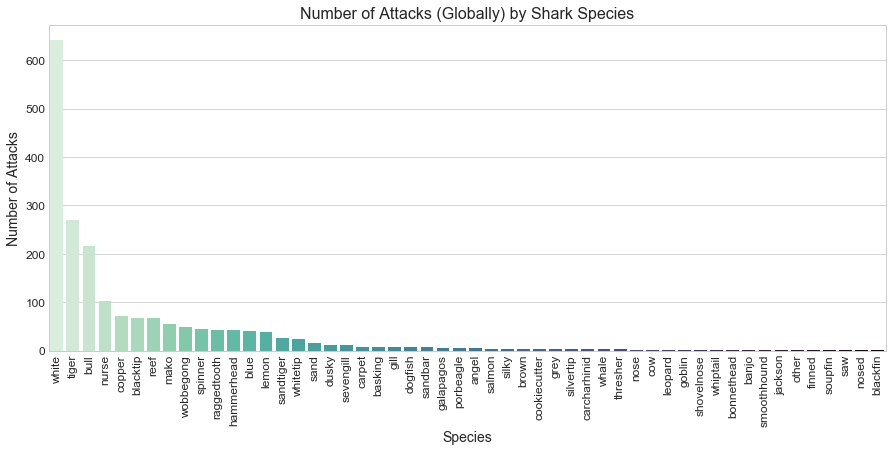

In [45]:
plt.style.use('seaborn-whitegrid')
sharks = ts_gsaf[ts_gsaf.shark_species != 'None Found']
fig = plt.figure(figsize=(15,6))
sns.countplot(sharks.shark_species, palette='mako_r', order=sharks['shark_species'].value_counts().index)
plt.title('Number of Attacks (Globally) by Shark Species', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Species', fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel('Number of Attacks', fontsize=14)
plt.show()

Great White, Tiger, Bull sharks are the three species accounting for the highest number of attacks world wide. All three of these species frequent the waters off the coast of the Carolinas and should then contribute a significant portion of the attacks in that area.

In [46]:
# Add a "count" column to the shark attack time series data to sum attacks per year
sharks['count'] = [1] * len(sharks)
ts_sharks = sharks.set_index(sharks.datetime)
ts_sharks = ts_sharks[['Type', 'Fatal (Y/N)', 'count']]
ts_sharks.head()

,Type,Fatal (Y/N),count
datetime,,,
2019-07-30,Provoked,N,1
2019-07-27,Unprovoked,N,1
2019-07-22,Unprovoked,N,1
2019-07-17,Unprovoked,N,1
2019-07-10,Unprovoked,N,1


In [47]:
# Resample global shark attack data to a yearly count
yearly = ts_sharks.resample('A').sum()
yearly.columns = ['Number of Attacks']

# Resample global shark attack data for a yearly count of provoked/unprovoked attacks
ts_provoked = ts_sharks[ts_sharks.Type=='Provoked'].resample('A').sum()
ts_unprovoked = ts_sharks[ts_sharks.Type=='Unprovoked'].resample('A').sum()
ts_otherType = ts_sharks[(ts_sharks.Type !='Provoked') & (ts_sharks.Type !='Unprovoked')].resample('A').sum()

# Rename columns
ts_unprovoked.columns = ['Unprovoked']
ts_provoked.columns = ['Provoked']
ts_otherType. columns = ['Other']

# combine series
ts_attack_type = pd.concat([ts_provoked, ts_unprovoked, ts_otherType], axis=1)

# Resample global shark attack data for a yearly count of fatal/nofatal attacks
ts_fatal = ts_sharks[ts_sharks['Fatal (Y/N)'] == 'Y'].resample('A').sum()
ts_nonfatal = ts_sharks[ts_sharks['Fatal (Y/N)'] == 'N'].resample('A').sum()

# Rename columns
ts_fatal.columns = ['Fatal']
ts_nonfatal.columns = ['Nonfatal']

# combine series
ts_fatality = pd.concat([ts_fatal, ts_nonfatal], axis=1)

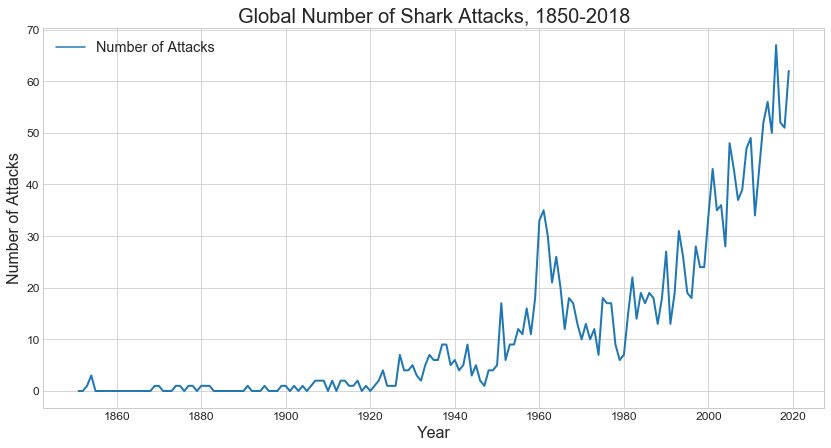

In [52]:
# Plot time series count of annual global shark attacks
fig = plt.figure(figsize=(14,7))
sns.lineplot(data=yearly['1850':'2018'], lw=2)
plt.title('Global Number of Shark Attacks, 1850-2018', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel('Number of Attacks', fontsize=16)
plt.yticks(fontsize=12)
plt.legend(fontsize='x-large')
plt.show()

The annual number of shark attacks began to rise around 1920. Poor reporting/information collection may be the cause of the low historical records of shark attacks prior to 1920. The local spike in attacks around 1960 is interesting and has yet to be explained. One theory is that the naval activities during the Vietnam War could have contributed to increased reporting of shark encounters.

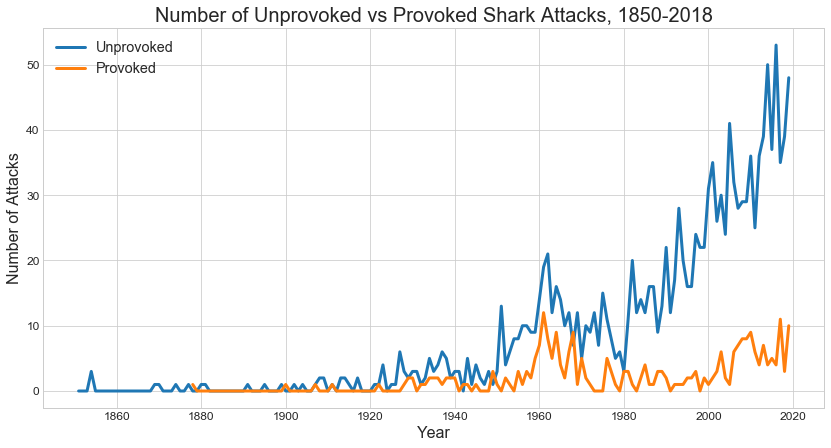

In [53]:
# Plot the number of provoked v. unprovoked shark attacks per year
fig = plt.figure(figsize=(14,7))

plt.plot(ts_unprovoked['Unprovoked']['1850':'2018'], lw=3, label='Unprovoked')
plt.plot(ts_provoked['Provoked']['1850':'2018'], lw=3, label='Provoked')

#plt.plot(ts_otherType['Other'], lw=3, label='Other', color='red')
plt.title('Number of Unprovoked vs Provoked Shark Attacks, 1850-2018', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel('Number of Attacks', fontsize=16)
plt.yticks(fontsize=12)
plt.legend(fontsize='x-large')
plt.show()

There are significantly more unprovoked attacks than provoked attacks over the past 50 years. While this is alrming as it suggests sharks often mistake humans/watercrafts as prey, at least humans have recognized that sharks can be dangerous and thus do not seek out encounters on a regular basis.

In [54]:
ts_attack_type = ts_attack_type.fillna(0)

def ts_percentage(ts1, ts2):
    return ts2 / (ts1 + ts2)

ts_attack_type['perc_unprovoked'] = ts_percentage(ts_attack_type.Provoked, ts_attack_type.Unprovoked)

print(f"Unprovoked attacks average {round(np.mean(ts_attack_type.perc_unprovoked)*100,2)} percent of the total number of attacks each year.")


Unprovoked attacks average 82.98 percent of the total number of attacks each year.


In [408]:
# fig = plt.figure(figsize=(15,7))
# ts_attack_type.perc_unprovoked['1940':'2018'].plot(kind='area', color='teal')

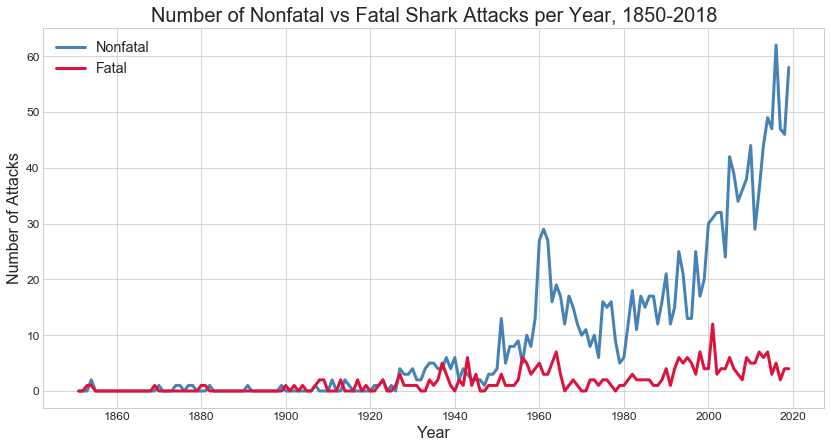

In [55]:
# Plot the number of fatal v. nonfatal shark attacks per year
fig = plt.figure(figsize=(14,7))

plt.plot(ts_nonfatal['1850':'2018'], lw=3, label='Nonfatal', color='steelblue')
plt.plot(ts_fatal['1850':'2018'], lw=3, label='Fatal', color='crimson')

#plt.plot(ts_otherType['Other'], lw=3, label='Other', color='red')
plt.title('Number of Nonfatal vs Fatal Shark Attacks per Year, 1850-2018', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel('Number of Attacks', fontsize=16)
plt.yticks(fontsize=12)
plt.legend(fontsize='x-large')
plt.show()

While the number of shark attacks has been increasing steadily over the past 50 years, the number of fatalities from the attacks remains relatively stable. This is by no means conclusive evidence, but it is suggestive that the uptick in shark attacks may be because people are invading their space more frequently and not necessarily that sharks are becoming more agressive.

In [56]:
ts_fatality['perc_fatal'] = ts_percentage(ts_fatality.Nonfatal, ts_fatality.Fatal)

print(f"Fatal attacks average {round(np.mean(ts_fatality.perc_fatal)*100,2)} percent of the total number of attacks each year.")
print(f"However, over the past 50 years fatal shark attacks only average {round(np.mean(ts_fatality['1968':].perc_fatal)*100,2)} of the total number of attacks each year.")



Fatal attacks average 27.25 percent of the total number of attacks each year.
However, over the past 50 years fatal shark attacks only average 12.53 of the total number of attacks each year.


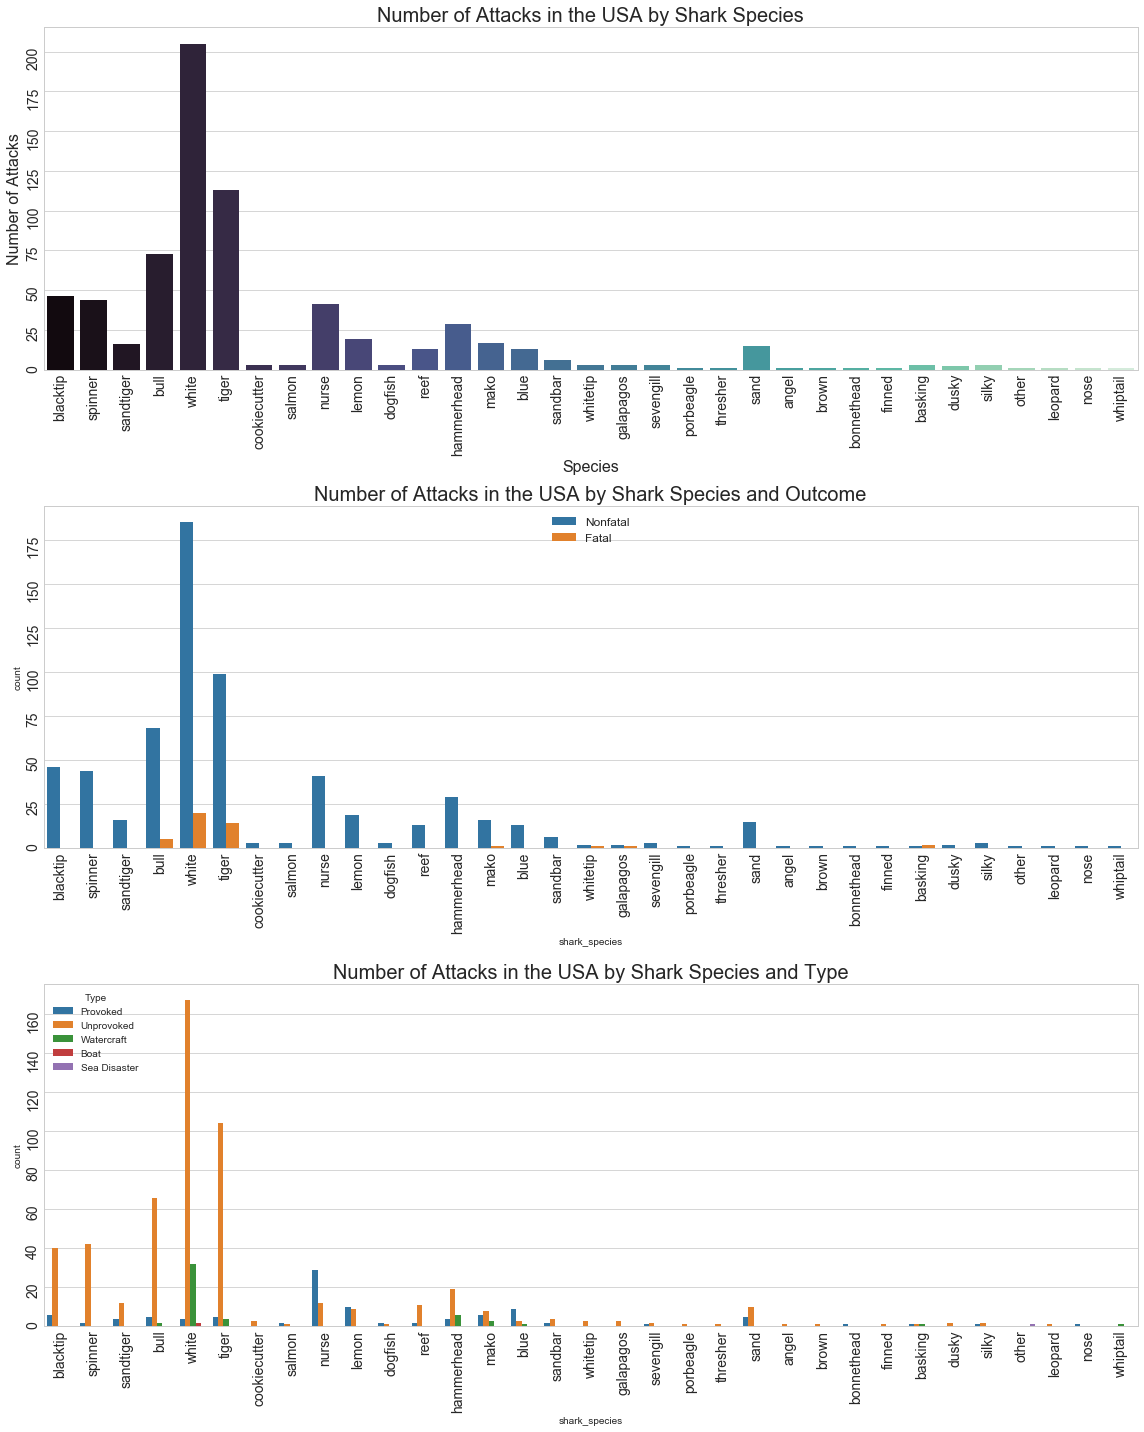

In [68]:
usa_sharks = sharks[(sharks.Country == 'USA') & (sharks.Type != 'Questionable') & (sharks.Type != 'Invalid') & 
                   (sharks['Fatal (Y/N)'] != 'UNKNOWN')]
fig, ax = plt.subplots(3,1,figsize=(16,20))

sns.countplot(x='shark_species', data=usa_sharks, palette='mako', ax=ax[0])
ax[0].set_title('Number of Attacks in the USA by Shark Species', fontsize=20)
ax[0].tick_params(labelrotation=90, labelsize=14)
ax[0].set_ylabel('Number of Attacks', fontsize=16)
ax[0].set_xlabel('Species', fontsize=16)

sns.countplot(x='shark_species', data=usa_sharks, hue='Fatal (Y/N)', ax=ax[1])
ax[1].set_title('Number of Attacks in the USA by Shark Species and Outcome', fontsize=20)
ax[1].tick_params(labelrotation=90, labelsize=14)
ax[1].legend(['Nonfatal', 'Fatal'], loc=0, fontsize='large')

sns.countplot(x='shark_species', data=usa_sharks, hue='Type', ax=ax[2])
ax[2].set_title('Number of Attacks in the USA by Shark Species and Type', fontsize=20)
ax[2].tick_params(labelrotation=90, labelsize=14)

plt.tight_layout()

As with the global data, Great White, Tiger, Bull sharks commit the greatest number of attacks in USA waters. Additionally, most of these attacks are unprovoked and nonfatal.

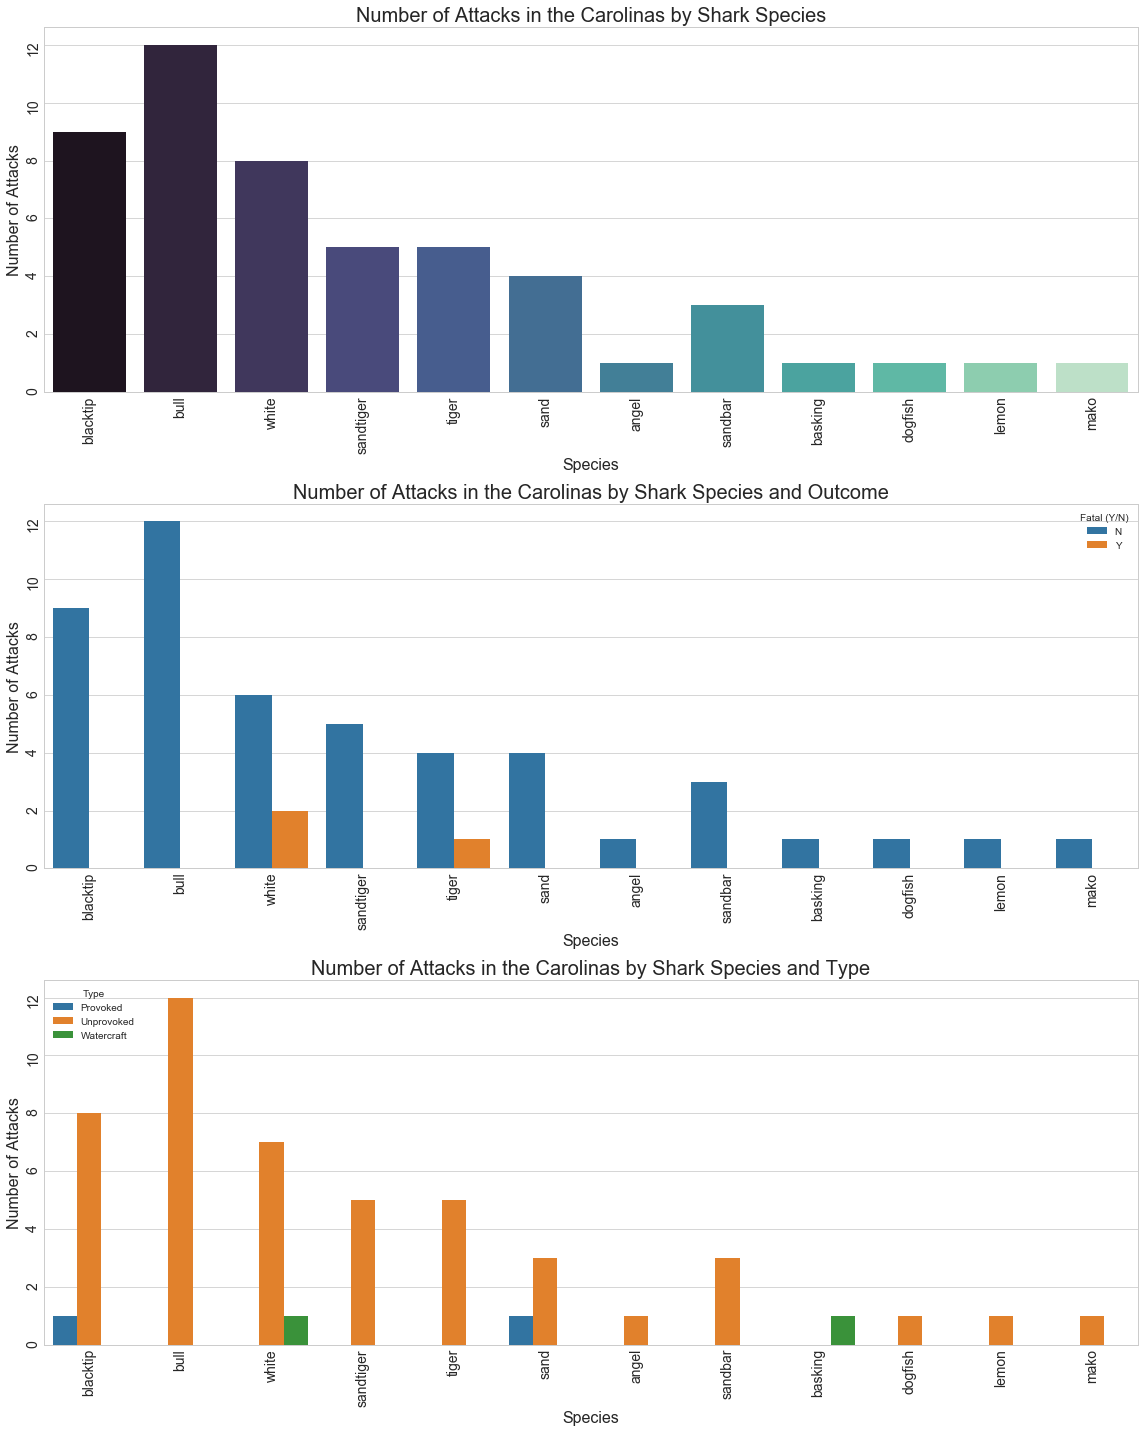

In [67]:
carolina_sharks = usa_sharks[(usa_sharks.Area == 'North Carolina') | (usa_sharks.Area == 'South Carolina')]

fig, ax = plt.subplots(3,1,figsize=(16,20))

sns.countplot(x='shark_species', data=carolina_sharks, palette='mako', ax=ax[0])
ax[0].set_title('Number of Attacks in the Carolinas by Shark Species', fontsize=20)
ax[0].tick_params(labelrotation=90, labelsize=14)
ax[0].set_ylabel('Number of Attacks', fontsize=16)
ax[0].set_xlabel('Species', fontsize=16)

sns.countplot(x='shark_species', data=carolina_sharks, hue='Fatal (Y/N)', ax=ax[1])
ax[1].set_title('Number of Attacks in the Carolinas by Shark Species and Outcome', fontsize=20)
ax[1].tick_params(labelrotation=90, labelsize=14)
ax[1].set_ylabel('Number of Attacks', fontsize=16)
ax[1].set_xlabel('Species', fontsize=16)

sns.countplot(x='shark_species', data=carolina_sharks, hue='Type', ax=ax[2])
ax[2].set_title('Number of Attacks in the Carolinas by Shark Species and Type', fontsize=20)
ax[2].tick_params(labelrotation=90, labelsize=14)
ax[2].set_ylabel('Number of Attacks', fontsize=16)
ax[2].set_xlabel('Species', fontsize=16)

plt.tight_layout()


Similar to the global data, Great White and Bull sharks are two of the top three species responsible for the greatest number of attacks in the Carolina region. However, Blacktip sharks have committed more attacks in this region than tiger sharks. Again, most of the attacks are unprovoked and nonfatal.

In [44]:
# Not useful!!

# carolina_sharks = carolina_sharks.set_index(carolina_sharks.datetime)
# carolina_yearly = carolina_sharks[['Type', 'Fatal (Y/N)', 'count']].resample('A').sum()
# fig = plt.figure(figsize=(14,7))
# sns.lineplot(data=carolina_yearly['1850':'2018'], lw=2)
# plt.title('Number of Shark Attacksin the Carolinas, 1850-2018', fontsize=20)
# plt.xlabel('Year', fontsize=16)
# plt.ylabel('Number of Attacks', fontsize=16)
# plt.show()

## Shark Attack Data for Carolina Region of the USA

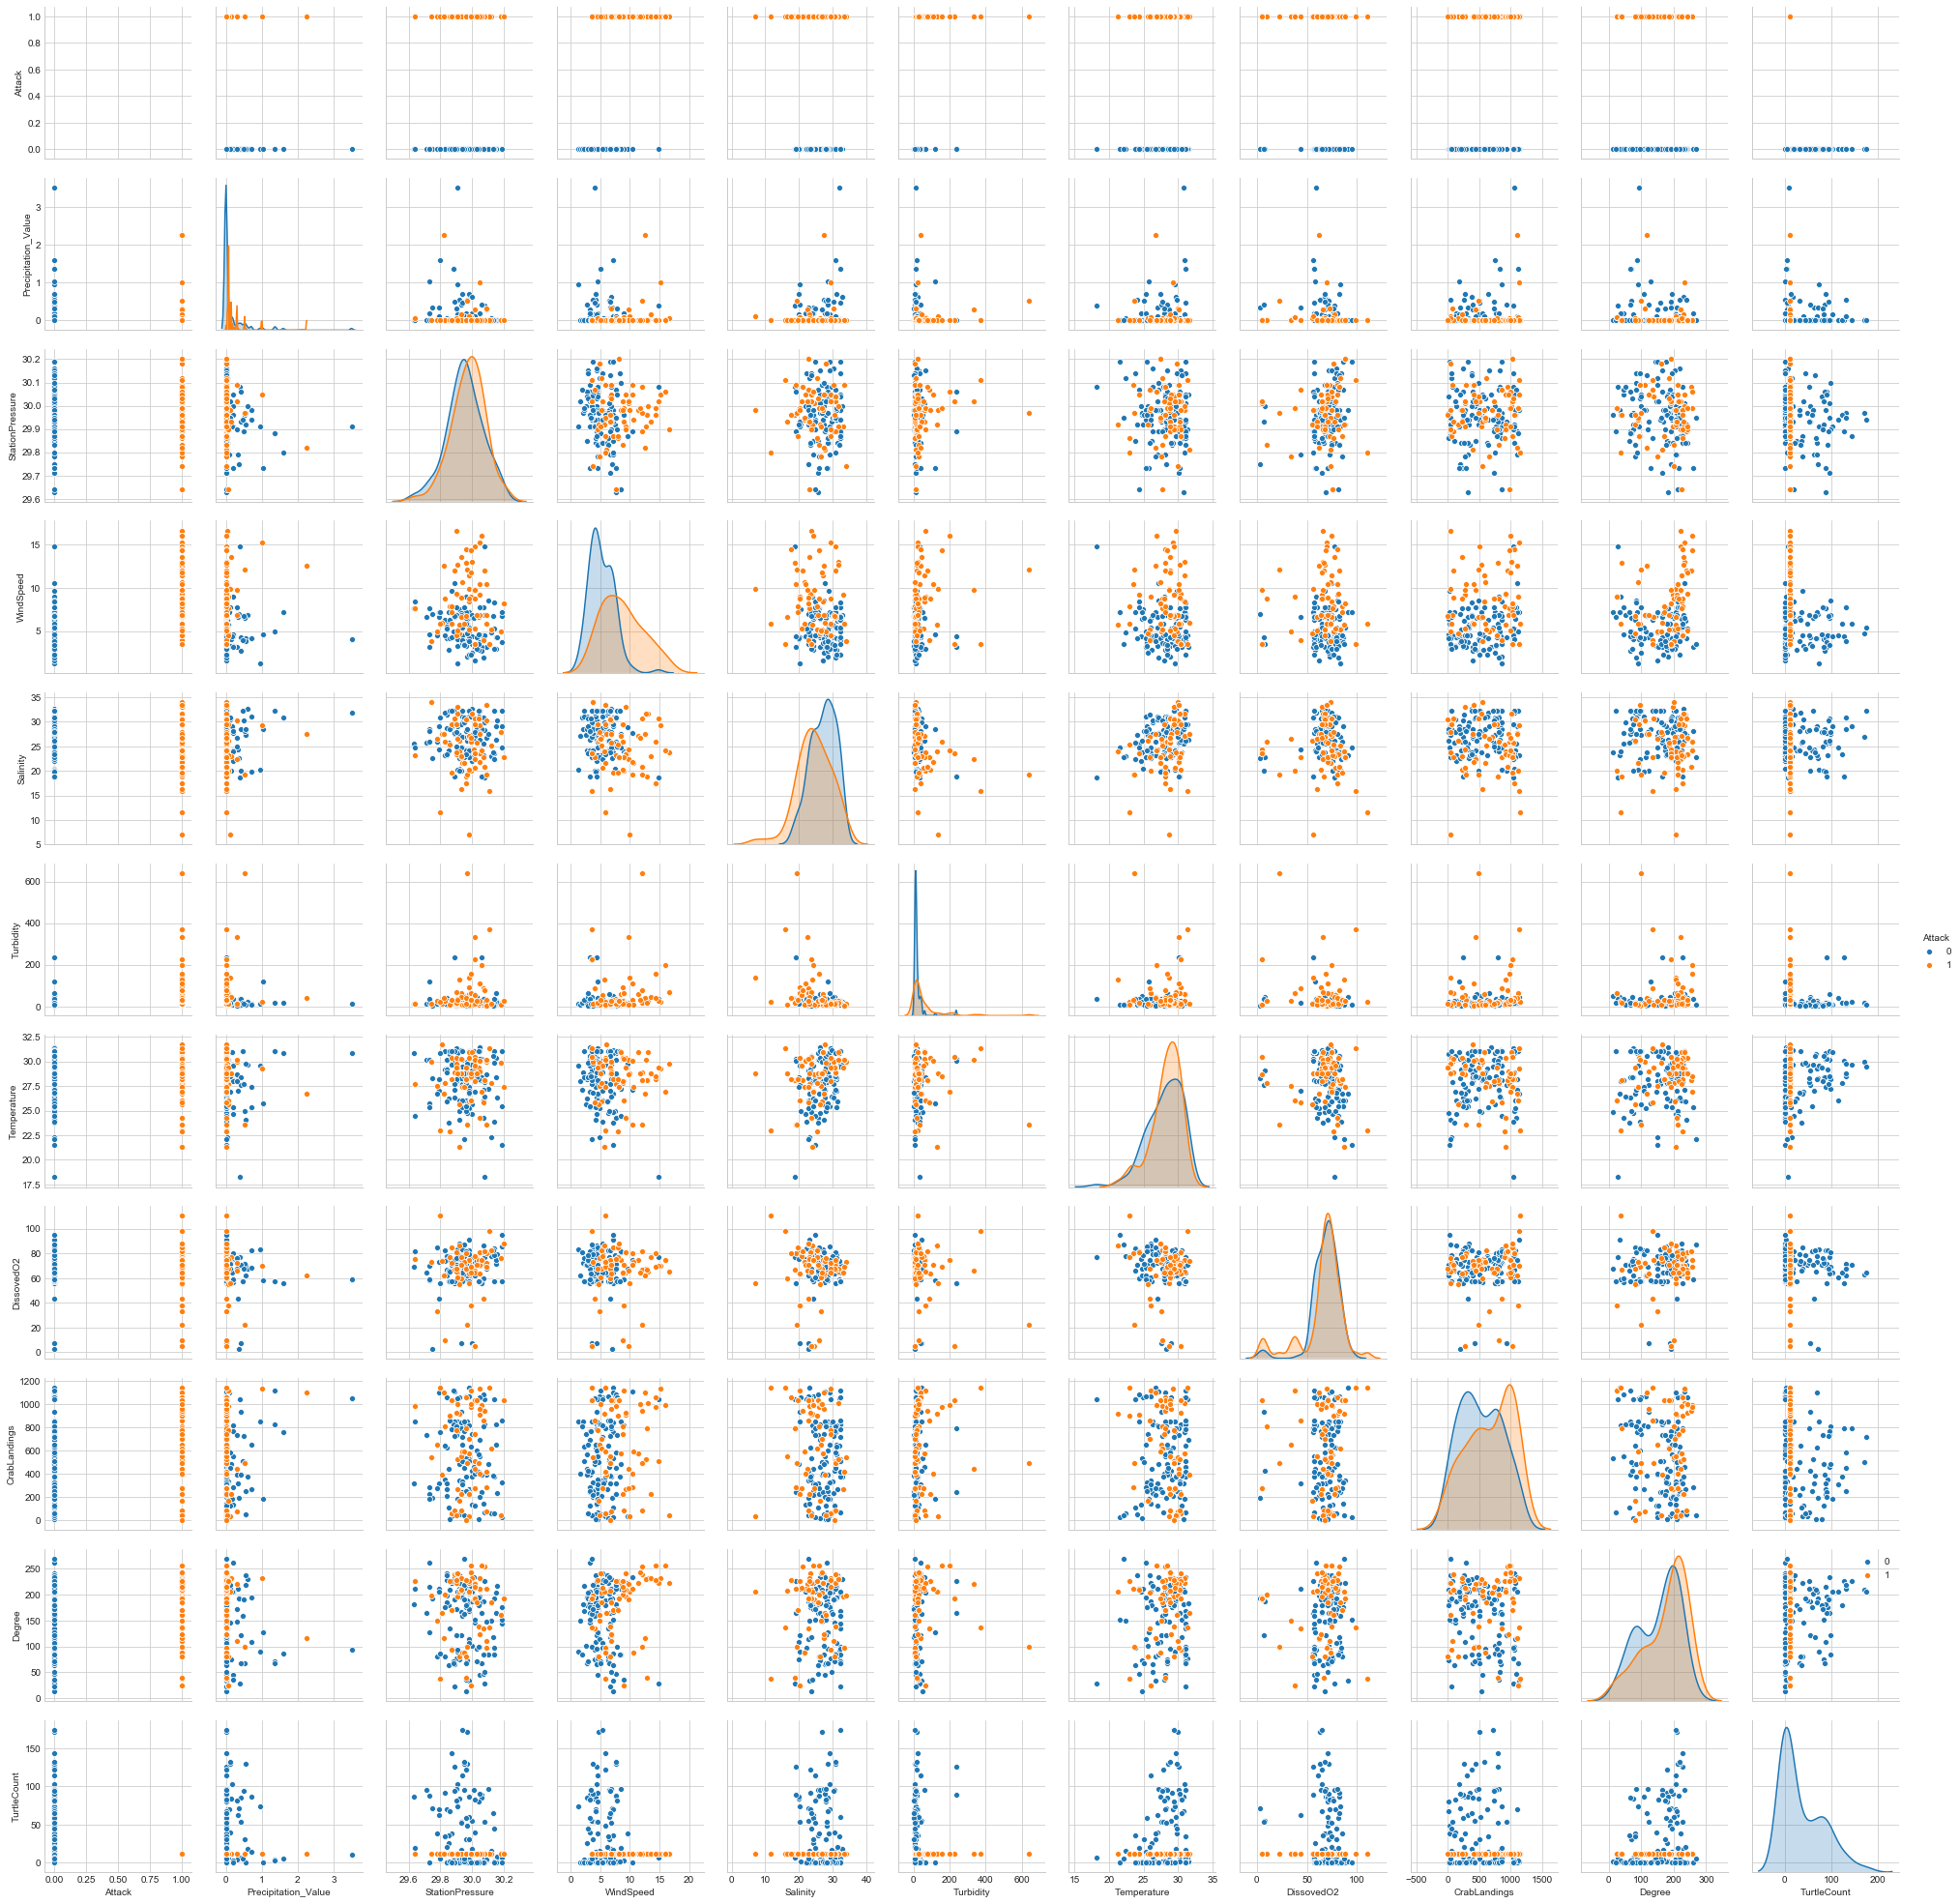

In [49]:
# Look for correlation with continuous variables
sns.pairplot(model_df, hue='Attack')
plt.legend()
plt.show()

**Analysis:** Looking at the distribution plots that run along the diagonal of the scatterplot matrix, it does appear that shark attacks happen more frequently when wind speed and number of crab landings are higher and when salinity is lower. Additionally there doesn't appear to be strong evidence of correlation between the features (multicolinearity), but this will examined further with a heatmap in the next cell. Lastly, the plot in the bottom right corner of the figure is odd as it suggests that shark attacks did not occur on days that a turtle count was recorded. This will also be examined further.

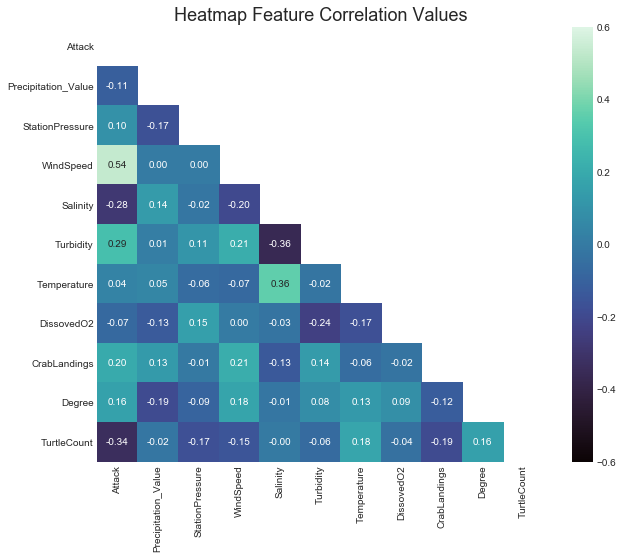

In [50]:
# Another check for correlation and multicollinearity
mask = np.zeros_like(model_df.corr())
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize=(10,8))
sns.heatmap(model_df.corr(), vmin=-.6, vmax=.6, mask=mask, cmap='mako', annot=True, fmt='.2f')
plt.title('Heatmap Feature Correlation Values', fontsize=18)
plt.show()

**Analysis:** Several features display moderate levels of correlation with the frequency of shark attacks. Wind speed shows the strongest positive correlation (0.5) with attacks, while salinity shows the strongest negative correlation (-0.3). These findings are in line with the conclusions drawn from the pairplot above. While it was difficult to determine from the pairplot, turbidity also shows a moderate positive correlation (0.3) with attacks when analyzed using this heatmap. Additionally, there does not appear to be strong evidence of multicolinearity as the strongest within-feature correlations are -0.4 (turbidity-salinity) and 0.4 (temperature-salinity). No action needs to be taken at this time to address multicolinearity as these interactions are moderate at best.

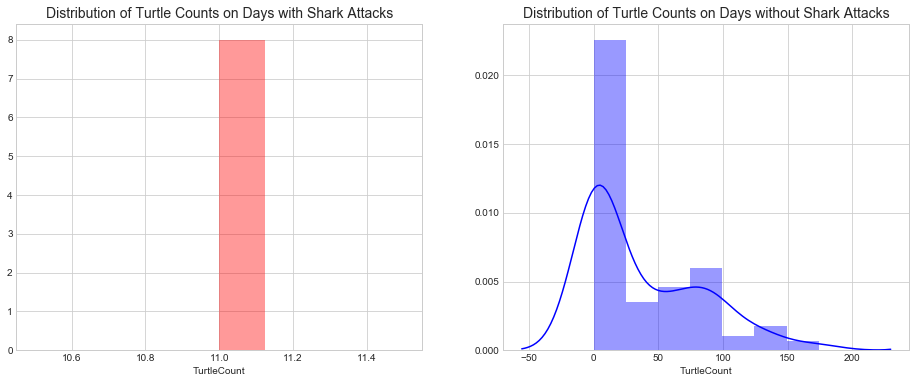

In [51]:
attacks = model_df[model_df.Attack == 1]
no_attacks = model_df[model_df.Attack == 0]

fig, ax = plt.subplots(1,2,figsize=(16,6))
sns.distplot(attacks.TurtleCount, color='red', ax=ax[0])
ax[0].set_title('Distribution of Turtle Counts on Days with Shark Attacks', fontsize=14)
sns.distplot(no_attacks.TurtleCount, color='blue', ax=ax[1])
ax[1].set_title('Distribution of Turtle Counts on Days without Shark Attacks', fontsize=14)
plt.show()

In [52]:
attacks.TurtleCount.value_counts()

11.0    68
Name: TurtleCount, dtype: int64

All of the turtle counts on the days that had shark attacks are equal to eleven, the median value of the column and the value that was used to impute Null values. For this reason, no strong conclusions from the TurtleCount data can be made as all of the data is imputed and will be dropped from dataset for modeling. 

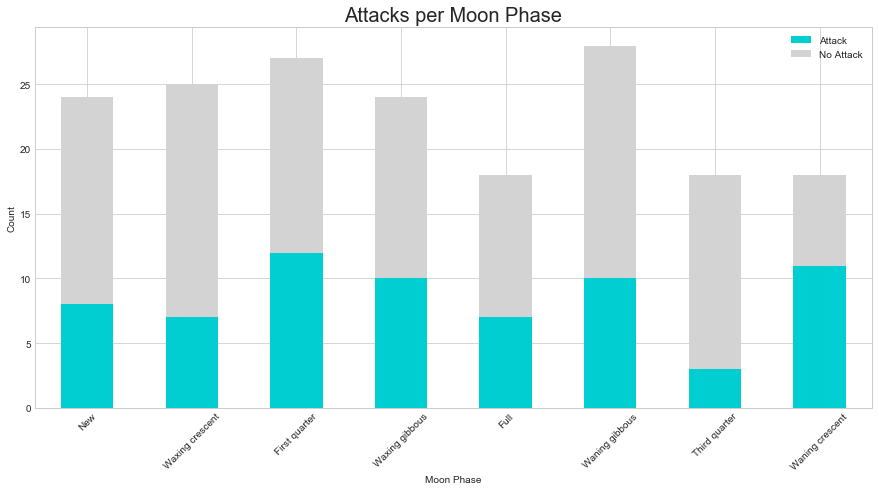

In [53]:
# plt.style.use('seaborn-whitegrid')
# Look for trend in categorical variable - MoonPhase



moonphase = ['New', 'Waxing crescent', 'First quarter', 'Waxing gibbous', 'Full', 'Waning gibbous', 'Third quarter', 
            'Waning crescent']

moon_total = []
moon_attack = []
for phase in moonphase:
    total_phase = len(model_df[model_df.MoonPhase == phase])
    attack_phase = len(attacks[attacks.MoonPhase == phase])
    moon_attack.append(attack_phase)
    moon_total.append(total_phase-attack_phase)
        
moon_freq_df = pd.DataFrame(np.array([moon_attack, moon_total]))
moon_freq_df.columns = moonphase
moon_freq_df.index = ['Attack', 'No Attack']


moon_freq_df.T.plot(kind='bar', stacked=True, colors=['darkturquoise', 'lightgrey'], figsize=(15,7))
plt.title('Attacks per Moon Phase', fontsize=20)
plt.xlabel('Moon Phase')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

The phase of the moon does not appear to have an effect on shark attack frequency as there seems to be a relatively equal distribution of attacks for each phase. Combining these finding with the time of the attack may provide more information as phases where more of the moon's surface are illuminated may make night time attacks more frequent. Attacks during dawn, dusk, and night time hours should be more frequent anyways as these are the times that most sharks feed ([Source](https://www.sharks-world.com/shark-behavior/)), but fewer people may be in the water at those times. However, the greater reflection of light off of the moon may make objects in the water close to the surface more visible during low-light times of day.

In [54]:
attack_dark = data2[(data2.Timeofattack == 'Dusk') | 
                    (data2.Timeofattack == 'Dawn') | 
                    (data2.Timeofattack == 'Evening')]

attack_light = data2[data2.Timeofattack == 'Day']

print('Dark: ', attack_dark.shape[0])
print('Light: ', attack_light.shape[0])

Dark:  25
Light:  39


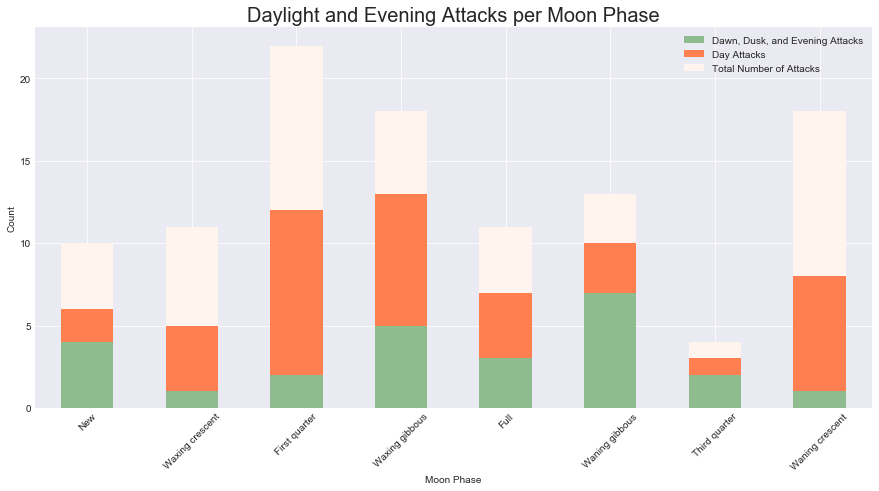

In [55]:
plt.style.use('seaborn-darkgrid')
moonphase = ['New', 'Waxing crescent', 'First quarter', 'Waxing gibbous', 'Full', 'Waning gibbous', 'Third quarter', 
            'Waning crescent']

moon_total = []
moon_attack = []
moon_day = []
for phase in moonphase:
    total_phase = len(attacks[attacks.MoonPhase == phase])
    attack_phase = len(attack_dark[attack_dark.MoonPhase == phase])
    day_attack = len(attack_light[attack_light.MoonPhase == phase])
    moon_attack.append(attack_phase)
    moon_total.append(total_phase-attack_phase)
    moon_day.append(day_attack)
        
moon_freq_df = pd.DataFrame(np.array([moon_attack, moon_day, moon_total]))
moon_freq_df.columns = moonphase
# moon_freq_df.index = ['Attack', 'No Attack']


moon_freq_df.T.plot(kind='bar', stacked=True, colors=['darkseagreen', 'coral', 'seashell'], figsize=(15,7)) 
plt.title('Daylight and Evening Attacks per Moon Phase', fontsize=20)
plt.xlabel('Moon Phase')
plt.xticks(rotation=45)
plt.ylabel('Count')
L = plt.legend()
L.get_texts()[2].set_text("Total Number of Attacks")
L.get_texts()[0].set_text("Dawn, Dusk, and Evening Attacks")
L.get_texts()[1].set_text("Day Attacks")
plt.show()

In general, there appear to be more attacks during the day rather than at night. This makes sense as more people are most likely in the water during the day. While moon phased do affect tidal range, they do not appear to have a significant effect on shark attack frequency in the Carolina region of the United States.

In [243]:
# def confirm_species(shark_list, species_list):
#     confirm_shark = []
    
#     iter_sharks = iter(shark_list)
#     shark = next(iter_sharks)
#     print(f"Current shark: {shark}")
    
#     for j in species_list:
#         if shark == 'None Found':
#             confirm_shark.append(shark)
#             shark = next(iter_sharks)
#             print(f"Current shark: {shark}")
#         elif shark == 'white':
#             confirm_shark.append(shark)
#             shark = next(iter_sharks)
#             print(f"Current shark: {shark}")
#         elif shark == 'saw':
#             confirm_shark.append(shark)
#             break
#         for i in list(range(0,len(species_list))):
#             if shark in species_list[i]:
#                 print(f"MATCH: {shark} and {species_list[i]}")
#                 confirm_shark.append(shark)
#                 shark = next(iter_sharks)
#                 print(f"Current shark: {shark}")
#             elif species_list[i] == 'leopard shark':
#                 #print(f"No match for {shark} and {species_list[i]}")
#                 shark = next(iter_sharks)
#                 print(f"Current shark: {shark}")
#             else:
#                 continue

#     return confirm_shark

To analyze which species of shark has the highest frequency of attacks, regex expressions will need to be used to parse through the unstructured strings in the ```Species``` column.

regex word before a word

\w+(?=\s+shark|\s+Shark)

In [131]:
# def regex_finder(expression, text):
#     pattern = expression
#     p = re.compile(pattern)
#     result = p.findall(text)
#     return result

In [376]:
# species = []
# for txt in attacks2.Species:  
    
#     shark = regex_finder('\w+(?=\s+shark|\s+Shark)', txt)
    
#     if len(shark) > 0:
#         shark_fin = max(set(shark), key=shark.count)
#         species.append(shark_fin.lower())
#     else:
#         species.append('None')
        
    

    
# attacks2['shark_species'] = species
# attacks2.head()

In [377]:
# attacks2.shark_species.value_counts()

In [378]:
# sharks_df = attacks2[(attacks2.shark_species == 'bull') | (attacks2.shark_species == 'blacktip') | 
#          (attacks2.shark_species == 'sandtiger') | (attacks2.shark_species == 'lemon') |
#         (attacks2.shark_species == 'tiger') | (attacks2.shark_species == 'mako')]
# sharks_df

In [379]:
# fig = plt.figure(figsize=(10,6))
# sns.countplot(sharks_df.shark_species, color='teal')
# plt.title('Number of Shark Attacks per Species')
# plt.show()

# Modeling

The goal of this section will be to determine which machine learning model performs the best at predicting shark attacks. The evaluation metrics used to determine which model is "best" will be based on: accuracy, F1 score, and ROC-AUC measures. The models tested will be: naive bayes, logistic regression, random forest, adaboost, gradient boosting. k-nearest, svc, and xgboost.

In [69]:
# Isolate target and features
y = model_df.Attack
x1 = model_df.drop(['Attack', 'Date'], axis=1)
x2 = model_df.drop(['Attack', 'MoonPhase', 'Date', 'TurtleCount'], axis=1) # Consider binning CrabLandings

In [70]:
x2.head()

,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2,CrabLandings,Degree
0,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556,1070,223.355556
1,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444,133,206.222222
2,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111,1061,212.111111
3,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444,341,222.977778
4,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444,1140,34.022222


In [71]:
# Import packages for preprocessing data
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [72]:
# Scale the features with MinMax to bring all values in the range [0,1]
min_max = MinMaxScaler()

minmax_x = pd.DataFrame(min_max.fit_transform(x2), columns=x2.columns)
minmax_x.head()

,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2,CrabLandings,Degree
0,0.000000,0.578947,0.333333,0.636021,0.032566,0.576733,0.741354,0.933566,0.819105
1,0.054286,0.649123,0.202614,0.552312,0.037936,0.477558,0.675088,0.114510,0.752212
2,0.000000,0.508772,0.405229,0.496314,0.027615,0.498185,0.703665,0.925699,0.775204
3,0.000000,0.508772,0.267974,0.579198,0.020119,0.575743,0.788776,0.296329,0.817630
4,0.000000,0.614035,0.385621,0.597837,0.066004,0.627393,0.822323,0.994755,0.079906


In [73]:
# Encode the categorical variables with labels
labeler = LabelEncoder()

labeled_moon = pd.Series(labeler.fit_transform(x1['MoonPhase']), name='MoonPhase', dtype='category')

final_x = pd.concat([minmax_x, labeled_moon], axis=1)
final_x.head()

,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2,CrabLandings,Degree,MoonPhase
0,0.000000,0.578947,0.333333,0.636021,0.032566,0.576733,0.741354,0.933566,0.819105,0
1,0.054286,0.649123,0.202614,0.552312,0.037936,0.477558,0.675088,0.114510,0.752212,0
2,0.000000,0.508772,0.405229,0.496314,0.027615,0.498185,0.703665,0.925699,0.775204,7
3,0.000000,0.508772,0.267974,0.579198,0.020119,0.575743,0.788776,0.296329,0.817630,7
4,0.000000,0.614035,0.385621,0.597837,0.066004,0.627393,0.822323,0.994755,0.079906,1


In [74]:
final_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 10 columns):
Precipitation_Value    182 non-null float64
StationPressure        182 non-null float64
WindSpeed              182 non-null float64
Salinity               182 non-null float64
Turbidity              182 non-null float64
Temperature            182 non-null float64
DissovedO2             182 non-null float64
CrabLandings           182 non-null float64
Degree                 182 non-null float64
MoonPhase              182 non-null category
dtypes: category(1), float64(9)
memory usage: 13.4 KB


In [75]:
# Import modeling and evaluation packages
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score

In [76]:
def model_assessment(model, n):
    """
    Function to calculate accuracy, f1-score, and AUC eval metrics for an SciKit Learn model over a specified number 
    of iterations.
    
    Input:
    model - tupel in the form of (instantiated_model_variable, alias_string)
    n - the number of times to run the model; integer
    
    Return:
    pandas dataframe containing eval metrics from the training and testing sets over n iterations
    
    """
    
    # Create empty lists to house eval metrics
    acc_train = []
    acc_test = []
    f1_train = []
    f1_test = []
    roc_auc_train = []
    roc_auc_test = []
    
    # isolate the string alias of the model
    model_name = model[1]
    
    # fit the model n number of times and record eval metrics for each iteration
    for i in range(n):
        
        # split the data into train and test sets. DO NOT set random seed to allow for variability
        X_train, X_test, y_train, y_test = train_test_split(final_x, y, test_size=0.2)
        
        # fit the model and generate predictions for the train and test sets
        model[0].fit(X_train, y_train)
        train_preds = model[0].predict(X_train)
        score_train = model[0].predict_proba(X_train)[:,1]
        test_preds = model[0].predict(X_test)
        score_test = model[0].predict_proba(X_test)[:,1]
        
        # calculate accuracy scores for train and test sets
        train_acc = accuracy_score(y_train, train_preds)
        acc_train.append(train_acc)
        test_acc = accuracy_score(y_test, test_preds)
        acc_test.append(test_acc)
        
        # calculate f1-scores for train and test sets
        train_f1 = f1_score(y_train, train_preds)
        f1_train.append(train_f1)
        test_f1 = f1_score(y_test, test_preds)
        f1_test.append(test_f1)
        
        # calculate auc for train and test sets
        train_roc_auc = roc_auc_score(y_train, score_train)
        roc_auc_train.append(train_roc_auc)
        test_roc_auc = roc_auc_score(y_test, score_test)
        roc_auc_test.append(test_roc_auc)
    
    # return df with eval metrics for all iterations
    return pd.DataFrame(np.array([acc_train, acc_test, f1_train, f1_test, roc_auc_train, roc_auc_test]).T, 
                        columns=[model_name+'_Training_Acc',model_name+'_Testing_Acc',model_name+'_Training_F1', 
                                 model_name+'_Testing_F1', model_name+'_Training_AUC', model_name+'_Testing_AUC'])

In [68]:
# Instantiate models
naive_bayes = GaussianNB()
logistic = LogisticRegression()
random_forest = RandomForestClassifier()
adaboost = AdaBoostClassifier()
gradient_boost = GradientBoostingClassifier()
knn = KNeighborsClassifier()
svc = SVC(probability=True) # to calculate AUC

# Create list of models and name alias
models = [(naive_bayes, 'naive_bayes'), (logistic, 'logistic'), (random_forest, 'random_forest'), 
          (adaboost, 'adaboost'), (gradient_boost, 'gradient_boost'), (knn, 'knn'), (svc, 'svc')]

In [69]:
# Iterate through the list of models and combine dfs to get single baseline df
df = []
for mod in models:
    df.append(model_assessment(mod, 1000)) # perform 1000 iterations
    
baseline_df = pd.concat(df, axis=1)
baseline_df.head()

,naive_bayes_Training_Acc,naive_bayes_Testing_Acc,naive_bayes_Training_F1,naive_bayes_Testing_F1,naive_bayes_Training_AUC,naive_bayes_Testing_AUC,logistic_Training_Acc,logistic_Testing_Acc,logistic_Training_F1,logistic_Testing_F1,...,knn_Training_F1,knn_Testing_F1,knn_Training_AUC,knn_Testing_AUC,svc_Training_Acc,svc_Testing_Acc,svc_Training_F1,svc_Testing_F1,svc_Training_AUC,svc_Testing_AUC
0,0.806897,0.810811,0.702128,0.695652,0.834470,0.823333,0.834483,0.756757,0.727273,0.666667,...,0.681319,0.476190,0.875308,0.806061,0.627586,0.810811,0.181818,0.363636,0.860564,0.718254
1,0.793103,0.864865,0.666667,0.827586,0.802912,0.812121,0.820690,0.702703,0.697674,0.521739,...,0.480000,0.380952,0.830830,0.755882,0.682759,0.783784,0.361111,0.333333,0.844107,0.761905
2,0.779310,0.891892,0.673469,0.818182,0.805985,0.918519,0.820690,0.783784,0.704545,0.636364,...,0.626506,0.689655,0.861869,0.802083,0.724138,0.621622,0.411765,0.222222,0.849410,0.611801
3,0.793103,0.756757,0.700000,0.571429,0.794293,0.851852,0.813793,0.783784,0.709677,0.600000,...,0.674699,0.416667,0.889456,0.807018,0.689655,0.648649,0.328358,0.000000,0.896162,0.567308
4,0.806897,0.837838,0.708333,0.769231,0.828246,0.863354,0.834483,0.756757,0.707317,0.689655,...,0.630435,0.521739,0.865051,0.735577,0.655172,0.675676,0.137931,0.250000,0.864672,0.791925


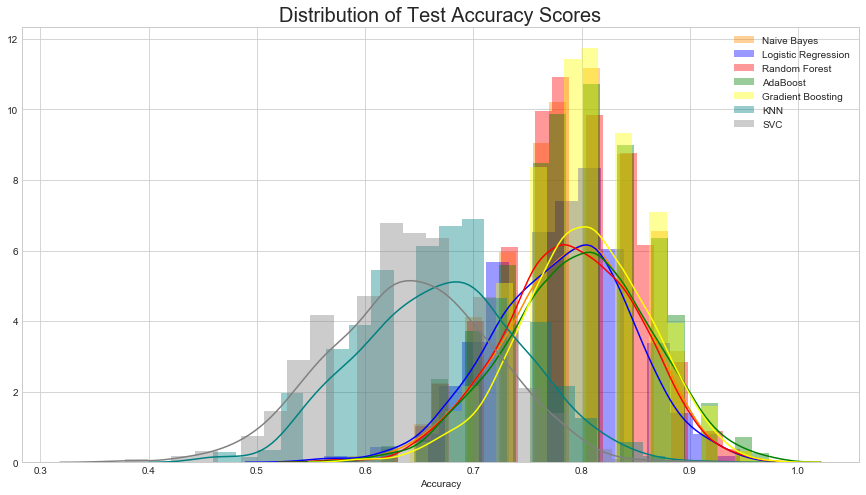

In [70]:
# Plot distribution of accuracy scores for each model evaluated on the testing set
plt.style.use('seaborn-whitegrid')

from scipy.stats import norm

fig = plt.figure(figsize=(15,8))

sns.distplot(baseline_df['naive_bayes_Testing_Acc'], color='darkorange', label='Naive Bayes')
sns.distplot(baseline_df['logistic_Testing_Acc'], color='blue', label='Logistic Regression')
sns.distplot(baseline_df['random_forest_Testing_Acc'], color='red', label='Random Forest')
sns.distplot(baseline_df['adaboost_Testing_Acc'], color='green', label='AdaBoost')
sns.distplot(baseline_df['gradient_boost_Testing_Acc'], color='yellow', label='Gradient Boosting')
sns.distplot(baseline_df['knn_Testing_Acc'], color='teal', label='KNN')
sns.distplot(baseline_df['svc_Testing_Acc'], color='grey', label='SVC')
plt.xlabel('Accuracy')
plt.title('Distribution of Test Accuracy Scores', fontsize=20)
plt.legend()
plt.show()

**Analysis:** The distribution of accuracy scores for the models evaluated on the testing set indicate that the KNN and SVC models performed the worst as their distributions are shifted to the left of the other distributions. The other five distributions (naive bayes, logistic regression, random forest, adaboost, and gradient boosting) are clustered relatively tightly, but the ditribution for gradient boosting does appear to be shifted the furthest right, indicating its accuracy scores were the highest.

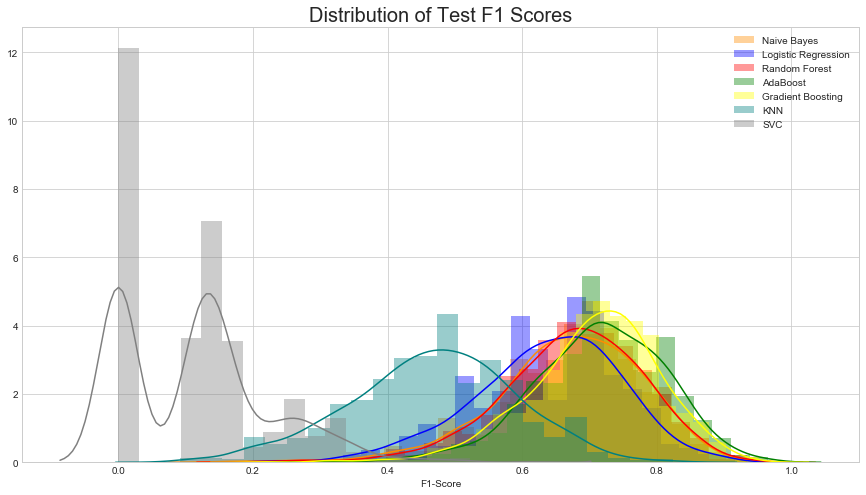

In [71]:
# Plot distribution of f1-scores for each model evaluated on the testing set

fig = plt.figure(figsize=(15,8))

sns.distplot(baseline_df['naive_bayes_Testing_F1'], color='darkorange', label='Naive Bayes')
sns.distplot(baseline_df['logistic_Testing_F1'], color='blue', label='Logistic Regression')
sns.distplot(baseline_df['random_forest_Testing_F1'], color='red', label='Random Forest')
sns.distplot(baseline_df['adaboost_Testing_F1'], color='green', label='AdaBoost')
sns.distplot(baseline_df['gradient_boost_Testing_F1'], color='yellow', label='Gradient Boosting')
sns.distplot(baseline_df['knn_Testing_F1'], color='teal', label='KNN')
sns.distplot(baseline_df['svc_Testing_F1'], color='grey', label='SVC')
plt.xlabel('F1-Score')
plt.title('Distribution of Test F1 Scores', fontsize=20)
plt.legend()
plt.show()

**Analysis:** A model's F1-Score is indicative of its overall performance as high precision and recall scores are needed for a high F1-Score. The positions of the distributions again suggest that the KNN and SVC models performed the worst on the classification task as their distributions are the fursthest to the left. Again the other five distributions are clustered together with means around 0.7. The distribution for the Adaboost model is located furthest to the right, indicating it produced the strongest F1-Score.

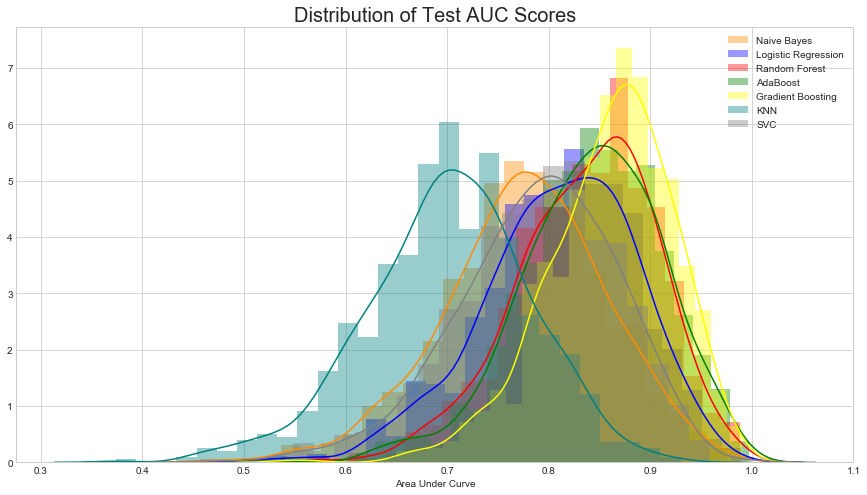

In [72]:
# Plot distribution of AUC scores for each model evaluated on the testing set

fig = plt.figure(figsize=(15,8))

sns.distplot(baseline_df['naive_bayes_Testing_AUC'], color='darkorange', label='Naive Bayes')
sns.distplot(baseline_df['logistic_Testing_AUC'], color='blue', label='Logistic Regression')
sns.distplot(baseline_df['random_forest_Testing_AUC'], color='red', label='Random Forest')
sns.distplot(baseline_df['adaboost_Testing_AUC'], color='green', label='AdaBoost')
sns.distplot(baseline_df['gradient_boost_Testing_AUC'], color='yellow', label='Gradient Boosting')
sns.distplot(baseline_df['knn_Testing_AUC'], color='teal', label='KNN')
sns.distplot(baseline_df['svc_Testing_AUC'], color='grey', label='SVC')
plt.xlabel('Area Under Curve')
plt.title('Distribution of Test AUC Scores', fontsize=20)
plt.legend()
plt.show()

**Analysis:** The AUC evaluation metric is another comprehensive measure of model performance like the F1-Score. The AUC refers to the area under the ROC curve. The ROC curve is a measure of the model's true positive rate versus its true negative rate. In simplest terms, AUC can be thought of as a measure of how well the model separated the two classes of the data. An AUC of 1 means the model classified every data point perfectly, where an AUC of 0.5 is equal to random guessing (in a dataset with balanced classes). Because the target class in this dataset only represents roughly 30% of all the observations, accuracy scores alone could be misleading. Thus, combining accuracy scores with AUC measures should provide a better view of model performance.

Again, KNN performed the worst as the distributions of its AUC scores are shifted furthest to the left. However, surprisingly the SVC model performed similarly to the other models, even though its accuracy and F1-scores were among the lowest tested. The distribution for the gradient bosting model appears to be the furthest right, indicating the best AUC measures. Additionally, the distribution of AUC for the gradient boosting model is the least spread out (has the highest peak), suggesting that its AUC scores were the most consistent (varied the least across the 1000 iterations.)

In [73]:
# Compare each model's training and testing eval metrics to assess for overfitting

avg_acc_train = []
avg_f1_train = []
avg_auc_train = []


avg_acc_test = []
avg_f1_test = []
avg_auc_test = []


for model in models:
    name = model[1]
    
    avg_acc_train.append(np.mean(baseline_df[name+'_Training_Acc']))
    avg_f1_train.append(np.mean(baseline_df[name+'_Training_F1']))
    avg_auc_train.append(np.mean(baseline_df[name+'_Training_AUC']))
    
    avg_acc_test.append(np.mean(baseline_df[name+'_Testing_Acc']))
    avg_f1_test.append(np.mean(baseline_df[name+'_Testing_F1']))
    avg_auc_test.append(np.mean(baseline_df[name+'_Testing_AUC']))
    
model_names = [i[1] for i in models]


baseline_avg_train = pd.DataFrame(np.array([avg_acc_train, avg_f1_train, avg_auc_train]).T, 
                                  columns=['accuracy', 'f1_score', 'AUC'], index=model_names)

baseline_avg_train['group'] = ['train'] * 7


baseline_avg_test = pd.DataFrame(np.array([avg_acc_test, avg_f1_test, avg_auc_test]).T, 
                                  columns=['accuracy', 'f1_score', 'AUC'], index=model_names)

baseline_avg_test['group'] = ['test'] * 7


baseline_avg_df = pd.concat([baseline_avg_train, baseline_avg_test], axis=0)

baseline_avg_df.reset_index(inplace=True)
baseline_avg_df.columns = ['model', 'accuracy', 'f1_score', 'AUC', 'group']
baseline_avg_df



,model,accuracy,f1_score,AUC,group
0,naive_bayes,0.809848,0.704158,0.818915,train
1,logistic,0.814490,0.695043,0.844644,train
2,random_forest,0.985090,0.979506,0.999409,train
3,adaboost,0.999759,0.999678,1.000000,train
4,gradient_boost,1.000000,1.000000,1.000000,train
5,knn,0.785234,0.662065,0.864646,train
6,svc,0.664586,0.181344,0.857809,train
7,naive_bayes,0.790432,0.668447,0.776020,test
8,logistic,0.781162,0.636974,0.809506,test
9,random_forest,0.789405,0.674443,0.836530,test


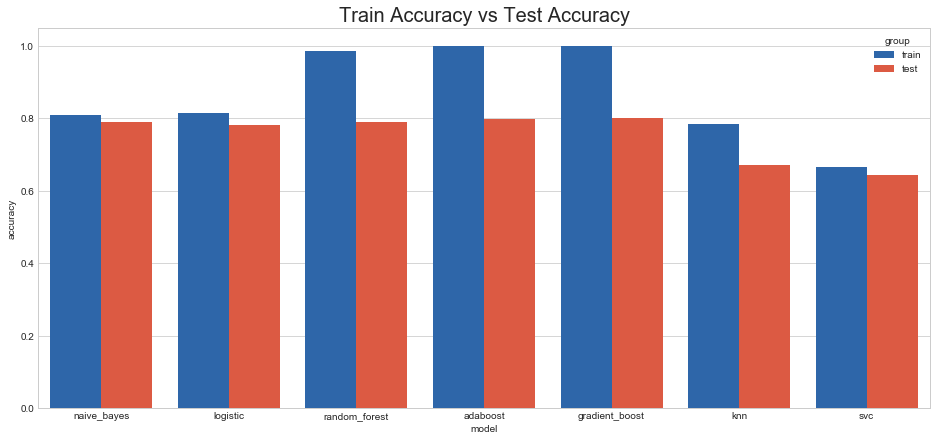

In [74]:
# Compare training and testing scores for accuracy
fig = plt.figure(figsize=(16,7))
sns.barplot(x='model', y='accuracy', data=baseline_avg_df, hue='group',  palette=['#1965bd', '#f5482a'])
plt.title('Train Accuracy vs Test Accuracy', fontsize=20)
plt.show()

The random forest, adaboost, and gradient boosting models display significant overfitting as their training scores averaged close to 100% accurate while their testing scores averaged closer to 80% accurate. This overfitting can be addressed with hyperparameter tuning/optimization. However, it is interesting to note that the naive bayes and logistic regression models achieved similar testing accuracy while displaying less overfitting. For this reason, it may be beneficial to include the naive bayes and logistic regression models instead of the random forest and adaboost models in subsequent iterations of model selection.

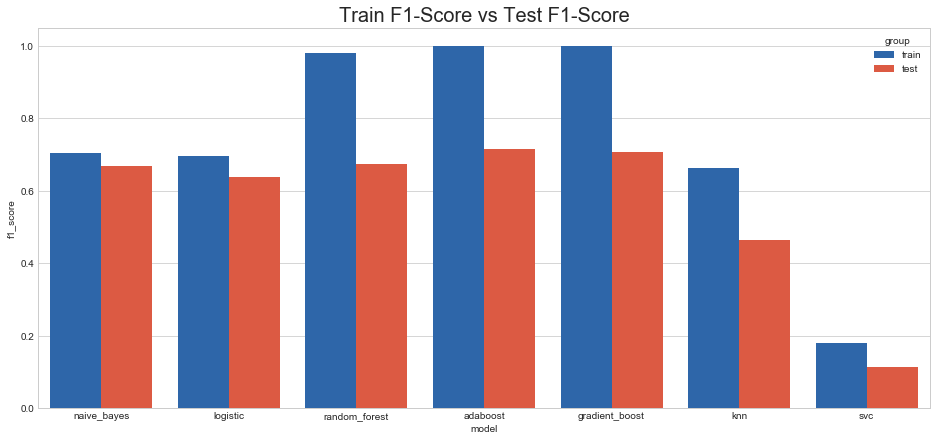

In [75]:
# Compare training and testing measures for F1-score

fig = plt.figure(figsize=(16,7))
sns.barplot(x='model', y='f1_score', data=baseline_avg_df, hue='group', palette=['#1965bd', '#f5482a'])
plt.title('Train F1-Score vs Test F1-Score', fontsize=20)
plt.show()

Again, the training F1-scores for the random forest, adaboost, and gradient boosting models are significantly higher than their testing value, further indicating overfitting to the training data. Naive bayes (0.676) slightly outperfroms the random forest (0.668) model with much less overfitting. This finding strengthens the conclusion to have the naive bayes model progress to subsequent iterations of model selection instead of the random forest model.

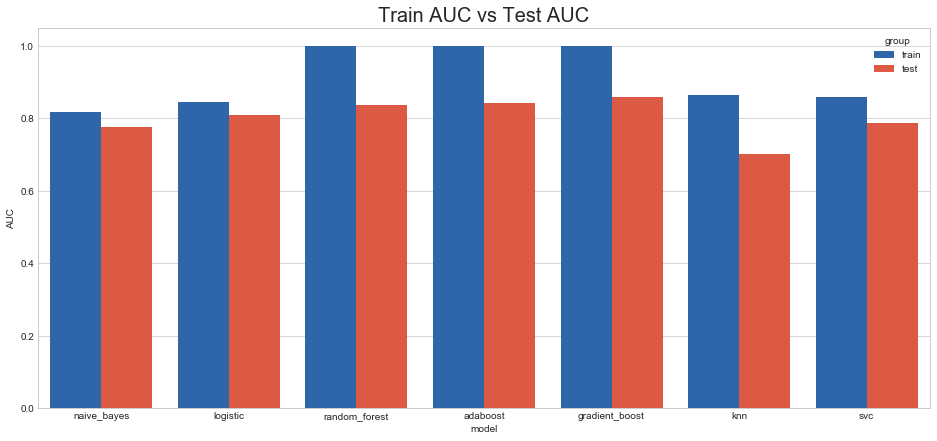

In [76]:
# Compare training and testing scores for AUC

fig = plt.figure(figsize=(16,7))
sns.barplot(x='model', y='AUC', data=baseline_avg_df, hue='group',  palette=['#1965bd', '#f5482a'])
plt.title('Train AUC vs Test AUC', fontsize=20)
plt.show()

Echoing the overfitting trends displayed in the figures for accuracy and F1-score, the random forest, adaboost, and gradient boosting models all have higher training AUC measures than their testing AUC measures. Additionally, the AUC measures for the naive bayes and logistic regression models are similar to the random forest model, but again with less overfitting. 

### Conclusion from Baseline Modeling

Based on analysis of the strength of each model's performance on the testing set and their evidence for overfitting, the gradient boosting, naive bayes, and logistic regression models will progress to subsequent iterations of model selection. Gradient boosting had the strongest performance of all the models, but it did display overfitting. Naive bayes and logistic regression performed similar to random forest and adaboost, but with less overfitting. The KNN and SVC models had the weakest performance across all measures.

Based on model performance across the three evaluation metrics, logistic regression and gradient boosting performed the best and will undergo hyperparameter tuning for optimization.

## Model Tuning and Optimization

The logistic regression and gradient boosting models will undergo hyperparameter tuning and optimization to limit overfitting and improve overall performance. They will again be evaluated based on accuracy, F1-score, and AUC.

[RandomizedSearchCV Docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)

[Example Comparing RandomizedSearchCV to GridSearchCV](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py)

In [77]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

RandomizedSearchCV is significantly more time and computationally efficient as it randomly selects hyperparameter values from a distribution and tests them over $n$ iterations, rather than exhaustively trying every value in a grid search. While GridSearchCV will find the best set of hyperparameters (assuming they are in the grid), it will waste significant resources on combinations that do not work. RandomizedSearchCV will find the hyperparameters that are "close enough" in terms of performance. Thus, RandomizedSearchCV will be used initially over a broad range of possible values to get the "ballpark" estimate. Then, a more targeted GridSearchCV will be performed to hone in on the "best" value for the hyperparameters.

[SciPy randint Docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.randint.html#scipy.stats.randint)


In [78]:
# Consider using randint(low, high) as it draws from a pmf instead of uniform distribution
from scipy.stats import randint as sp_randint

In [ ]:
# produces list of scoring metrics that can be called by name to eval models with GridSearchCV
# and RandomizedSearchCV

# import sklearn.metrics as sk_metrics
# sorted(sk_metrics.SCORERS.keys())

In [79]:
# Run RandomizedSearchCV to find the best parameters for the models

# instantiate models
naive_bayes = GaussianNB()
logistic = LogisticRegression()
gradient_boost = GradientBoostingClassifier()

# define parameter grids
nb_params = {'var_smoothing': np.random.uniform(low=0.0000000001, high=0.0001, size=5)}
log_params = {'penalty': ['l1', 'l2'],
             'C': np.random.uniform(low=0.1, high=1.5, size=500),
             'solver': ['liblinear', 'saga']}

gb_params = {'loss': ['deviance', 'exponential'],
             'learning_rate': np.random.uniform(low=0.001, high=0.3, size=500),
            'min_samples_leaf': np.random.randint(low=1, high=4, size=100),
            'max_depth': np.random.randint(low=3, high=30, size=500),
            'max_features': [None, 'sqrt', 'log2']}

#(naive_bayes, nb_params, 'Naive Bayes'),

models = [(logistic, log_params, 'Logistic'), (naive_bayes, nb_params, 'Naive Bayes'),
          (gradient_boost, gb_params, 'Gradient Boosting')]

In [80]:
def eval_report (results):
    """ Utility function to aid in the display of a formatted print statement containing the 
    top-ranked model when evaluated on AUC, F1-Score, and Accuracy.
    
    results: randomized_search_object.cv_results_ or grid_search_object.cv_results_
    
    Returns a formatted print statement of the AUC, F1, Accuracy scores, and parameters for
    the top-ranked model in each of the scoring categories
    
    """
    
    top_auc = np.flatnonzero(results['rank_test_AUC'] == 1)[0]
    top_f1 = np.flatnonzero(results['rank_test_F1-Score'] == 1)[0]
    top_acc = np.flatnonzero(results['rank_test_Accuracy'] == 1)[0]

    print("Model with top AUC rank:")
    print("Mean AUC score: {0:.3f} (std: {1:.3f})".format(
          results['mean_test_AUC'][top_auc],
          results['std_test_AUC'][top_auc]))
    print("Mean F1-Score score: {0:.3f} (std: {1:.3f})".format(
          results['mean_test_F1-Score'][top_auc],
          results['std_test_F1-Score'][top_auc]))
    print("Mean Accuracy score: {0:.3f} (std: {1:.3f})".format(
          results['mean_test_Accuracy'][top_auc],
          results['std_test_Accuracy'][top_auc]))
    print("Best AUC Parameters: {0}".format(results['params'][top_auc]))
    print("")


    print("Model with top F1-Score rank:")
    print("Mean AUC score: {0:.3f} (std: {1:.3f})".format(
          results['mean_test_AUC'][top_f1],
          results['std_test_AUC'][top_f1]))
    print("Mean F1-Score score: {0:.3f} (std: {1:.3f})".format(
          results['mean_test_F1-Score'][top_f1],
          results['std_test_F1-Score'][top_f1]))
    print("Mean Accuracy score: {0:.3f} (std: {1:.3f})".format(
          results['mean_test_Accuracy'][top_f1],
          results['std_test_Accuracy'][top_f1]))
    print("Best F1-Score Parameters: {0}".format(results['params'][top_f1]))
    print("")


    print("Model with top Accuracy rank:")
    print("Mean AUC score: {0:.3f} (std: {1:.3f})".format(
          results['mean_test_AUC'][top_f1],
          results['std_test_AUC'][top_f1]))
    print("Mean F1-Score score: {0:.3f} (std: {1:.3f})".format(
          results['mean_test_F1-Score'][top_f1],
          results['std_test_F1-Score'][top_f1]))
    print("Mean Accuracy score: {0:.3f} (std: {1:.3f})".format(
          results['mean_test_Accuracy'][top_acc],
          results['std_test_Accuracy'][top_acc]))
    print("Best Accuracy Parameters: {0}".format(results['params'][top_acc]))
    print("")

In [81]:
# custom eval metrics for model evaluation
scoring = {'AUC': 'roc_auc', 'F1-Score': 'f1', 'Accuracy': 'accuracy'}

# declare randomized search iterations
n_iter_search = 50

# Iterate through the models to evaluate and run RandomizedSearchCV
for model in models:
    
    # creates a randomized search cv object (similar to instantiating a model/gridsearch)
    random_search = RandomizedSearchCV(model[0], param_distributions=model[1],
                                       n_iter=n_iter_search, cv=5, refit='F1-Score', 
                                       scoring=scoring, iid=False, random_state=26)
    
    # Fit the randomized search cv object to the entire dataset (because doing cv)
    random_search.fit(final_x, y)
    
    # Print statement to help organize displayed results
    print(f"RESULTS FOR {model[2].upper()} MODEL:")
    print("")

    # Use utility function on the random_search results dictionary
    eval_report(random_search.cv_results_)

RESULTS FOR LOGISTIC MODEL:

Model with top AUC rank:
Mean AUC score: 0.782 (std: 0.205)
Mean F1-Score score: 0.653 (std: 0.153)
Mean Accuracy score: 0.787 (std: 0.088)
Best AUC Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1.39869433670436}

Model with top F1-Score rank:
Mean AUC score: 0.782 (std: 0.205)
Mean F1-Score score: 0.653 (std: 0.153)
Mean Accuracy score: 0.787 (std: 0.088)
Best F1-Score Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1.39869433670436}

Model with top Accuracy rank:
Mean AUC score: 0.782 (std: 0.205)
Mean F1-Score score: 0.653 (std: 0.153)
Mean Accuracy score: 0.787 (std: 0.088)
Best Accuracy Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1.39869433670436}

RESULTS FOR NAIVE BAYES MODEL:

Model with top AUC rank:
Mean AUC score: 0.700 (std: 0.211)
Mean F1-Score score: 0.597 (std: 0.153)
Mean Accuracy score: 0.732 (std: 0.117)
Best AUC Parameters: {'var_smoothing': 9.384010042440261e-05}

Model with top F1-Score rank:
Mean AUC

In [83]:
# Perform GridSearchCV to hone in on the values that scored the best during RandomSearchCV

# instantiate models
naive_bayes = GaussianNB()
logistic = LogisticRegression()
gradient_boost = GradientBoostingClassifier()

# define parameter grids
nb_grid_params = {'var_smoothing': [0.00003,0.00004,0.00005,0.00006,0.00007,0.00008,0.00009,0.0001]}
log_grid_params = {'penalty': ['l2'],
             'C': [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0],
             'solver': ['liblinear']}

gb_grid_params = {'loss': ['exponential'],
             'learning_rate': [0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24],
            'min_samples_leaf': [2,3,4],
            'max_depth': [5,6,7,8],
            'max_features': ['sqrt', 'log2']}

models = [(logistic, log_grid_params, 'Logistic'), (naive_bayes, nb_grid_params, 'Naive Bayes'),
          (gradient_boost, gb_grid_params, 'Gradient Boosting')]

In [85]:
# Iterate through the models to evaluate and run GridSearchCV
for model in models:
    
    # creates a randomized search cv object (similar to instantiating a model/gridsearch)
    grid_search = GridSearchCV(model[0], param_grid=model[1],
                               cv=5, refit='F1-Score', 
                               scoring=scoring, iid=False)
    
    # Fit the randomized search cv object to the entire dataset (because doing cv)
    grid_search.fit(final_x, y)
    
    # Print statement to help organize displayed results
    print(f"RESULTS FOR {model[2].upper()} MODEL:")
    print("")

    # Use utility function on the random_search results dictionary
    eval_report(grid_search.cv_results_)

RESULTS FOR LOGISTIC MODEL:

Model with top AUC rank:
Mean AUC score: 0.783 (std: 0.206)
Mean F1-Score score: 0.653 (std: 0.153)
Mean Accuracy score: 0.787 (std: 0.088)
Best AUC Parameters: {'C': 1.3, 'penalty': 'l2', 'solver': 'liblinear'}

Model with top F1-Score rank:
Mean AUC score: 0.782 (std: 0.205)
Mean F1-Score score: 0.659 (std: 0.154)
Mean Accuracy score: 0.787 (std: 0.088)
Best F1-Score Parameters: {'C': 1.8, 'penalty': 'l2', 'solver': 'liblinear'}

Model with top Accuracy rank:
Mean AUC score: 0.782 (std: 0.205)
Mean F1-Score score: 0.659 (std: 0.154)
Mean Accuracy score: 0.787 (std: 0.088)
Best Accuracy Parameters: {'C': 1.2, 'penalty': 'l2', 'solver': 'liblinear'}

RESULTS FOR NAIVE BAYES MODEL:

Model with top AUC rank:
Mean AUC score: 0.701 (std: 0.211)
Mean F1-Score score: 0.597 (std: 0.153)
Mean Accuracy score: 0.732 (std: 0.117)
Best AUC Parameters: {'var_smoothing': 0.0001}

Model with top F1-Score rank:
Mean AUC score: 0.698 (std: 0.210)
Mean F1-Score score: 0.597 

The logistic and gradient boosting models performed the best after `RandomizedSearchCv` and `GridSearchCV`. Because the logistic regression model had the highest scores across the three evaluation metrics (ROCAUC, F1, and Accuracy), it will be used at the final model to predict shark attacks in the Carolina Region of the United States.

The parameter values that optimized the performance of the logistic regression model the best were:
* `solver = "liblinear"`
* `penalty = "l2"`
* `C = 1.2`
    * NOTE: Based on the structure of the results dictionary returned from `GridSearchCV` (and `RandomizedSearchCV`), different sets of parameters can have the same rank if their scores for the particular evaluation metric are equal. The `eval_report` function addresses multiple sets of parameters with equal rank by returning the set in index position 0. This is the reason why the evaluation scores for the top ranked F1 model and top ranked Accuracy model are the same, yet the value of their C parameters are different. The C parameter represents the inverse of the regularization strength. Thus, smaller values indicate stronger regularization. Therefore, the smaller of the two returned values (1.2) will be used in the final model.
    
## Create Final Model

In [93]:
#X_train, X_test, y_train, y_test = train_test_split(final_x, y, test_size=0.15)

shark_model = LogisticRegression(penalty='l2', solver='liblinear', C=1.2)

shark_model_eval = model_assessment((shark_model, 'Logistic_Shark_Model'), 300)

shark_model_eval.head()

,Logistic_Shark_Model_Training_Acc,Logistic_Shark_Model_Testing_Acc,Logistic_Shark_Model_Training_F1,Logistic_Shark_Model_Testing_F1,Logistic_Shark_Model_Training_AUC,Logistic_Shark_Model_Testing_AUC
0,0.820690,0.756757,0.690476,0.640000,0.827493,0.876471
1,0.800000,0.729730,0.674157,0.583333,0.841473,0.782609
2,0.855172,0.702703,0.769231,0.476190,0.880480,0.672619
3,0.806897,0.864865,0.725490,0.705882,0.847458,0.837302
4,0.813793,0.810811,0.696629,0.666667,0.842424,0.887821


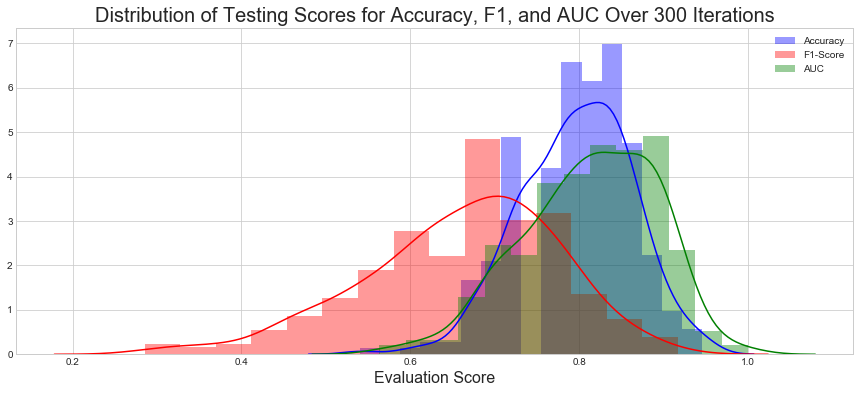

In [95]:
fig = plt.figure(figsize=(15,6))
sns.distplot(shark_model_eval['Logistic_Shark_Model_Testing_Acc'], color='blue', label='Accuracy')
sns.distplot(shark_model_eval['Logistic_Shark_Model_Testing_F1'], color='Red', label='F1-Score')
sns.distplot(shark_model_eval['Logistic_Shark_Model_Testing_AUC'], color='Green', label='AUC')
plt.title('Distribution of Testing Scores for Accuracy, F1, and AUC Over 300 Iterations', fontsize=20)
plt.xlabel('Evaluation Score', fontsize=16)
plt.legend()

plt.show()

In [108]:
# Compare each model's training and testing eval metrics to assess for overfitting

avg_acc_train = []
avg_f1_train = []
avg_auc_train = []


avg_acc_test = []
avg_f1_test = []
avg_auc_test = []

    
avg_acc_train.append(np.mean(shark_model_eval['Logistic_Shark_Model_Training_Acc']))
avg_f1_train.append(np.mean(shark_model_eval['Logistic_Shark_Model_Training_F1']))
avg_auc_train.append(np.mean(shark_model_eval['Logistic_Shark_Model_Training_AUC']))

avg_acc_test.append(np.mean(shark_model_eval['Logistic_Shark_Model_Testing_Acc']))
avg_f1_test.append(np.mean(shark_model_eval['Logistic_Shark_Model_Testing_F1']))
avg_auc_test.append(np.mean(shark_model_eval['Logistic_Shark_Model_Testing_AUC']))



model_avg_train = pd.DataFrame(np.array([avg_acc_train, avg_f1_train, avg_auc_train]),
                               columns=['eval_metric'], index=['Accuracy', 'F1-Score', 'AUC'])


model_avg_train['group'] = ['train']*3


model_avg_test = pd.DataFrame(np.array([avg_acc_test, avg_f1_test, avg_auc_test]), 
                                  columns=['eval_metric'], index=['Accuracy', 'F1-Score', 'AUC'])

model_avg_test['group'] = ['test']*3


model_avg_df = pd.concat([model_avg_train, model_avg_test], axis=0)

model_avg_df.columns = ['eval_metric', 'group']
model_avg_df

,eval_metric,group
Accuracy,0.815793,train
F1-Score,0.703601,train
AUC,0.846357,train
Accuracy,0.796216,test
F1-Score,0.660003,test
AUC,0.812946,test


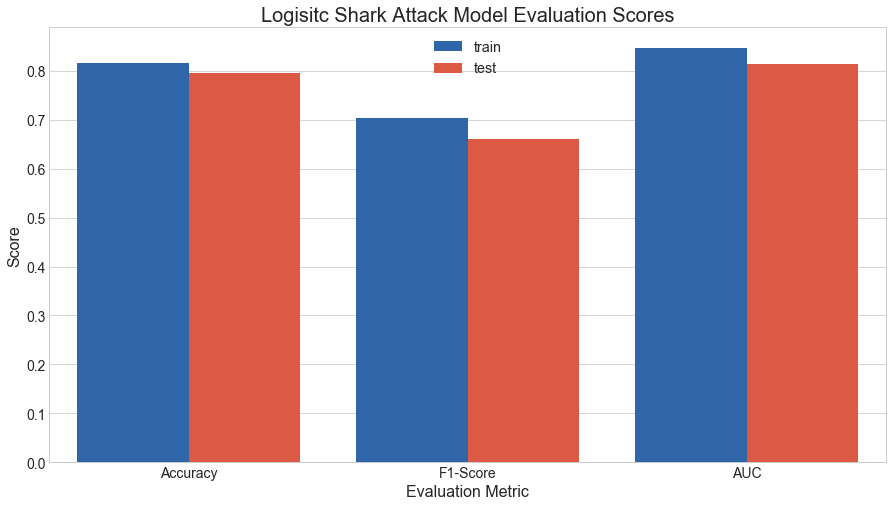

In [115]:
fig = plt.figure(figsize=(15,8))

sns.barplot(x=model_avg_df.index, y='eval_metric', data=model_avg_df, hue='group', palette=['#1965bd', '#f5482a'])
plt.xlabel('Evaluation Metric', fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Score', fontsize=16)
plt.yticks(fontsize=14)
plt.title('Logisitc Shark Attack Model Evaluation Scores', fontsize=20)
plt.legend(fontsize='x-large')
plt.show()

In [123]:
from sklearn.metrics import classification_report

In [125]:
# Train shark_model on entire dataset and view final performance scores. Compare to baseline logistic scores

shark_model.fit(final_x, y)

final_preds = shark_model.predict(final_x)

score_final = shark_model.predict_proba(final_x)[:,1]

final_acc = accuracy_score(y, final_preds)
final_f1 = f1_score(y, final_preds)
final_auc = roc_auc_score(y, score_final)

print("Final Model Performance: \n")
print(f"Accuracy: {round(final_acc,3)} (baseline - 0.781)")
print(f"F1-Score: {round(final_f1, 3)} (baseline - 0.637)")
print(f"AUC: {round(final_auc,3)} (baseline - 0.810)")

print("\n", classification_report(y, final_preds))

Final Model Performance: 

Accuracy: 0.819 (baseline - 0.781)
F1-Score: 0.708 (baseline - 0.637)
AUC: 0.846 (baseline - 0.810)

               precision    recall  f1-score   support

           0       0.80      0.96      0.87       114
           1       0.89      0.59      0.71        68

   micro avg       0.82      0.82      0.82       182
   macro avg       0.84      0.77      0.79       182
weighted avg       0.83      0.82      0.81       182



## Interpret Model

In [126]:
import shap

In [127]:
# load JS visualization code to notebook
shap.initjs()

In [266]:
# Create an explainer for the final shark model
explainer = shap.LinearExplainer(shark_model, final_x)

# Calculate shap values for the entire dataset
shap_values = explainer.shap_values(final_x)


The dtype of `shap_values` was originally "object". This was resulting in the error "Attribute Error: 'float' has no attribute 'rint'. Changed the dtype of `shap_values` to `np.float` with the following code: `np.array(shap_values, dtype=np.float)` and issue was resolved.

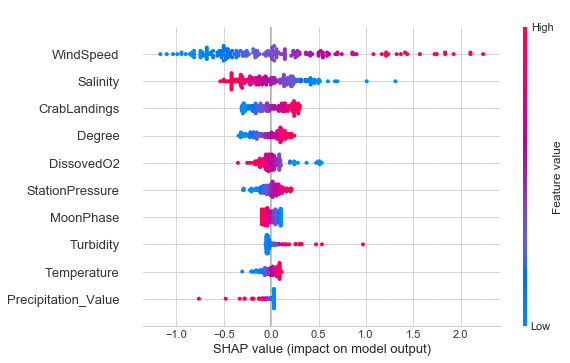

In [204]:
# Change the dtype of shap_values to np.float to get around error described above
shap_values2 = np.array(shap_values, dtype=np.float)

# Generate summary_plot to determine feature importance
shap.summary_plot(shap_values2, final_x)

The figure above is a summary plot of the shap values calculated for each feature in the final shark model. The more spread out the shap values are indicates a greater impact on the value of the model's prediction. Based on the figure, `WindSpeed` has the highest impact (in both directions) on the model's prediction. Furthermore, by analyzing the color of the dots, higher values of `WindSpeed` (red) drive the prediction towards "attack" and lower values of `WindSpeed` (blue) drive the prediction towards "no attack." The `Salinity` feature has the next highest impact on the model's prediction and displays the opposite trend in value magnitude from `WindSpeed`. For this feature, lower values of salinity (blue) drive the prediction towards the "attack" class whereas higher values of salinity (red) drive the prediction towards the "no attack" class.

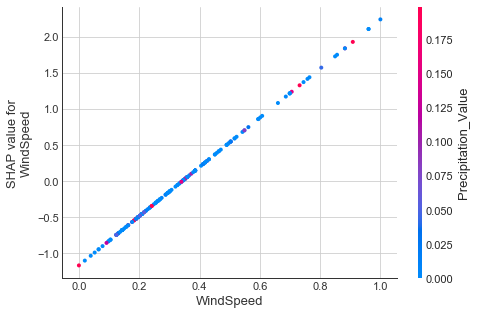

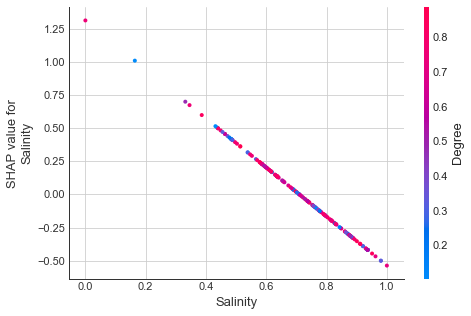

In [349]:
# Create dependence plots for the top two features

shap.dependence_plot('WindSpeed', shap_values2, final_x)
shap.dependence_plot('Salinity', shap_values2, final_x)


The two plots above display the interaction of selected features and their impact on the model's predictions. The values along the x-axis represent the feature's actual value from the dataset, while the values along the y-axis indicate that feature's calculated SHAP value. The plot function automatically selects another feature to color the doats of the plot based on how much it interacts with the feature selected for the x-axis.

It is not surprising that both plots demonstrate near perfect linearity as the explainer selected for this model was the `LinearExplainer`. Furthermore, the slopes of this two plots refelct the trends seen in the `summary_plot`. Higher values of `WindSpeed` pushed the model's prediction towards the "attack" class. Thus, we see a positive slope. However, higher values of `Salinity` pushed the model's prediction towards the "no attack" class. Thus, we see a negative slope.

In [273]:
# Create a force plot for all instances in the dataset
shap.force_plot(explainer.expected_value, shap_values2, final_x, link="logit")

The figure above displays the prediction for each instance as a sum of its effects from the features. The instances are ordered based on their output value to better highlight the contributions of the features. The instances with a greater portion of their graph in red were classified as an "attack" and the instances with a greater portion of their graph in blue were classified as "no attack."

In [217]:
# Generate list of indicies for misclassified instances

misses = y == final_preds

missed_preds = []

for i in misses.index:
    if misses[i] == False:
        missed_preds.append(i)
    
missed_preds

[2,
 7,
 25,
 39,
 44,
 51,
 62,
 65,
 80,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 131,
 135,
 136,
 139,
 144,
 145,
 147,
 152,
 162,
 165,
 166,
 167,
 168,
 178,
 179,
 180]

In [347]:
#Create a force plot to display the feature impact for individual instances (using link='logit' returns probabilities)

idx = 62

print(f"Ground-Truth: {y[idx]}")
print(f"Prediction: {final_preds[idx]}")
shap.force_plot(explainer.expected_value, shap_values[idx,:], final_x.iloc[idx,:], link='logit') 


Ground-Truth: 0
Prediction: 1


The figure above displays the `force_plot` for an individual instance. Like the `force_plot` created for all instances in the dataset, this plot displays the prediction as a sum of the effects from each feature. Features driving the prediction towards the "attack" class are shown in red and the features driving the prediction towards  the "no attack" class are shown in blue. This plost can be used to investigate why particular instances were misclassified in an attempt to improve model performance.

In [336]:
# Create a list of indecies for predictions in the "no attack" class
no_attack = final_preds == 0

no_attack_preds = []

for i, val in enumerate(no_attack):
    if no_attack[i] == True:
        no_attack_preds.append(i)

In [341]:
# Create a list of indecies of the misclassified predictions in the "no attack" class
missed_no_attack = [idx for idx in missed_preds if idx in no_attack_preds]
missed_no_attack

idx_missed_no_attack = []

for i, pred in enumerate(no_attack_preds):
    for j in missed_no_attack:
        if pred == j:
            idx_missed_no_attack.append(i)
            
idx_missed_no_attack

[23,
 41,
 60,
 71,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136]

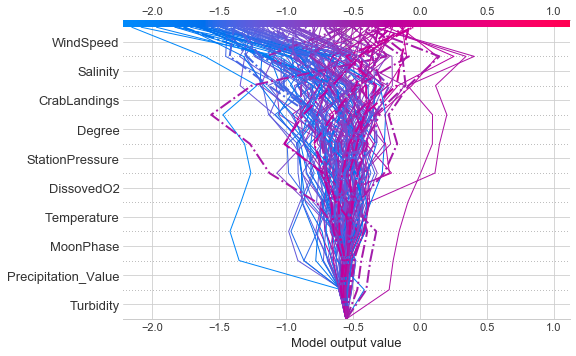

In [345]:
# Plot the prediction paths for the "no attack" class predictions and highlight the misclassifications (dashed)
shap.decision_plot(explainer.expected_value, shap_values2[no_attack_preds], final_x.columns,
                  y_demarc_color='black', highlight=idx_missed_no_attack)

The `dependence_plot` shown above displays a different method of viewing the same information in the `force_plot`. Each line represents an instance and the position of the line along the x-axis represents its value for each feature listed on the y-axis. The features are arranged such that the most impactful feature for the data points displayed is at the top of the graph and the least impactful feature is at the bottom.

The data displayed in this `dependence_plot` is of the predictions generated for the "no attack" class. Instances that were misclassified as "no attack" are shown with a dashed line. The benefits of this graph is that it can help identify common predictions paths and help determine if their are outliers. The lines that deviate from the bulk of the lines indicate that there may be some outliers. However, all except for one of the misclassified instances do not appear to be outliers. This calls into questions how much benefit the model's performance will receive from removing outliers.

In [343]:
# Create a list of indecies for predictions in the "attack" class
attack = final_preds == 1

attack_preds = []

for i, val in enumerate(attack):
    if attack[i] == True:
        attack_preds.append(i)

# Create a list of indecies of the misclassified predictions in the "attack" class
missed_attack = [idx for idx in missed_preds if idx in attack_preds]
missed_attack

idx_missed_attack = []

for i, pred in enumerate(attack_preds):
    for j in missed_attack:
        if pred == j:
            idx_missed_attack.append(i)
            
idx_missed_attack

[0, 1, 2, 3, 4]

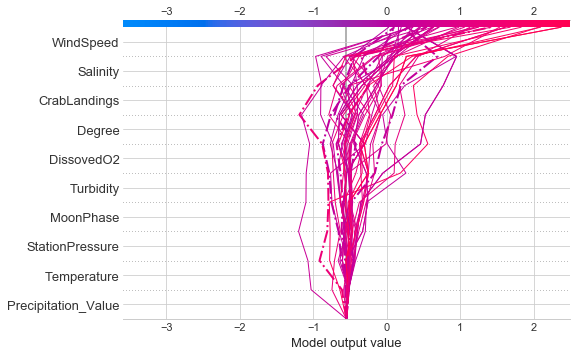

In [346]:
# Plot the prediction paths for the "attack" class predictions and highlight the misclassifications (dashed)
shap.decision_plot(explainer.expected_value, shap_values2[attack_preds], final_x.columns,
                  y_demarc_color='black', highlight=idx_missed_attack)

The `dependence_plot` above is the same as the previous plot, except it dispays the predictions generated for the "attack" class. Again, it shows the common prediction paths and indicates that there may be a few outliers with the presence of lines deviating from the bulk of the other lines. The misclassified predictions for the "attack" class are also shown with a dashed line. Like the misclassified predictions in the "no attack" class, these misclassified instances do not appear to be among the potential outliers, which dampens the expectation of significant improvement from their removal.

# Project Summary

<img src="https://media.giphy.com/media/xUPGcoQ8sfEbaP2JYA/giphy.gif">

This project built a logistic regression model that predicts shark attacks in the Carolina region of the United States with 81.9% accuracy and an f1-score of 0.71. This model uses various oceanic, astrological, meteorological, and marine life factors as features from a dataset comprised of 182 observations. As data was limited, the distribution of scores across 1000 iterations with bootstrap resampling of training/testing set was used to evaluate the performance of candidate models (Naive Bayes, Logistic Regression, KNN, SVC, Random Forest, AdaBoost, and Gradient Boosting). The Logisitc Regression, Naive Bayes, and Gradient Boosting performed the best and displayed the least overfitting during baseline evaluations. RandomSearchCV followed by GridSearchCV was used to tune hyperparameters of these models and it was found that logisitc regression had the highest performance measures. 

Shap values were used to assess the logistic regession model after it was trained on the entire dataset. It was found that the variation in wind speed values had the greatest impact on the model's prediction where higher wind speed values are correlated with increased frequency in shark attacks. The second greatest impact on the model's prediction came from salinity, which displayed an opposite trend as wind speed, higher salinity values are correlated with a lower frequency of shark attacks. Further analysis of the shap values indicates that there may be some outliers in some of the features (especially wind speed) and that removing them may improve model performance.

### Recommendations
- Check weather before engaging in water activities as higher winds were associated with an increased frequency of shark attacks.
- Avoid water activities when salinity levels are low as these were also correlated with a greater instance of shark attacks
- Two of the top three species of shark involved in the most attacks globally are present in the Carolina region. Learn to recognize these species and immediately exit the water if seen.

### Future Work
- Gather more data to increase the model performance.
- Extend work performed during this project to regions beyond the east coast of the United States.
- Create a dashboard/app to display risks and model predictions to aid in decision to participate in water activities.

**Similar Project** https://www.dataquest.io/blog/shark-attack-data-rise-humans-impact-oceans/